In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# Set global plot style and parameters
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [20, 5]  # Set figure size
plt.rcParams["figure.dpi"] = 100  # Set figure resolution


In [3]:

df = pd.read_pickle("../../../data/interim/01_data_processes.pkl")
df


gyr_x     acc_x     acc_y     acc_z   gyr_y   gyr_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200 -1.8904  0.013500  0.977000 -0.071000  2.4392  0.9388   
2019-01-11 15:08:05.400 -1.6826 -0.001500  0.970500 -0.079500 -0.8904  2.1708   
2019-01-11 15:08:05.600  2.5608  0.001333  0.971667 -0.064333 -0.2560 -1.4146   
2019-01-11 15:08:05.800  8.0610 -0.024000  0.957000 -0.073500 -4.5244 -2.0730   
2019-01-11 15:08:06.000  2.4390 -0.028000  0.957667 -0.115000 -1.5486 -3.6098   
...                         ...       ...       ...       ...     ...     ...   
2019-01-20 17:33:27.000  1.4146 -0.048000 -1.041500 -0.076500 -5.6218  0.2926   
2019-01-20 17:33:27.200 -2.7684 -0.037000 -1.030333 -0.053333 -0.5854  2.2440   
2019-01-20 17:33:27.400  2.8416 -0.060000 -1.031000 -0.082000 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.2318 -0.038667 -1.025667 -0.044667  0.2562  1.1220   
2019-01-20 17:33:27.800  1.0980 -0.044000 -1.034000 -0.059000 -4.0240  0.9760   

                         label category participant   set  set'  
epoch (ms)                                                       
2019-01-11 15:08:05.200  bench    heavy           B  64.0    64  
2019-01-11 15:08:05.400  bench    heavy           B  64.0    64  
2019-01-11 15:08:05.600  bench    heavy           B  64.0    64  
2019-01-11 15:08:05.800  bench    heavy           B  64.0    64  
2019-01-11 15:08:06.000  bench    heavy           B  64.0    64  
...                        ...      ...         ...   ...   ...  
2019-01-20 17:33:27.000    row   medium           E  71.0    71  
2019-01-20 17:33:27.200    row   medium           E  71.0    71  
2019-01-20 17:33:27.400    row   medium           E  71.0    71  
2019-01-20 17:33:27.600    row   medium           E  71.0    71  
2019-01-20 17:33:27.800    row   medium           E  71.0    71  

[9009 rows x 11 columns]

<AxesSubplot: title={'center': 'acc_x'}, xlabel='[label]'>

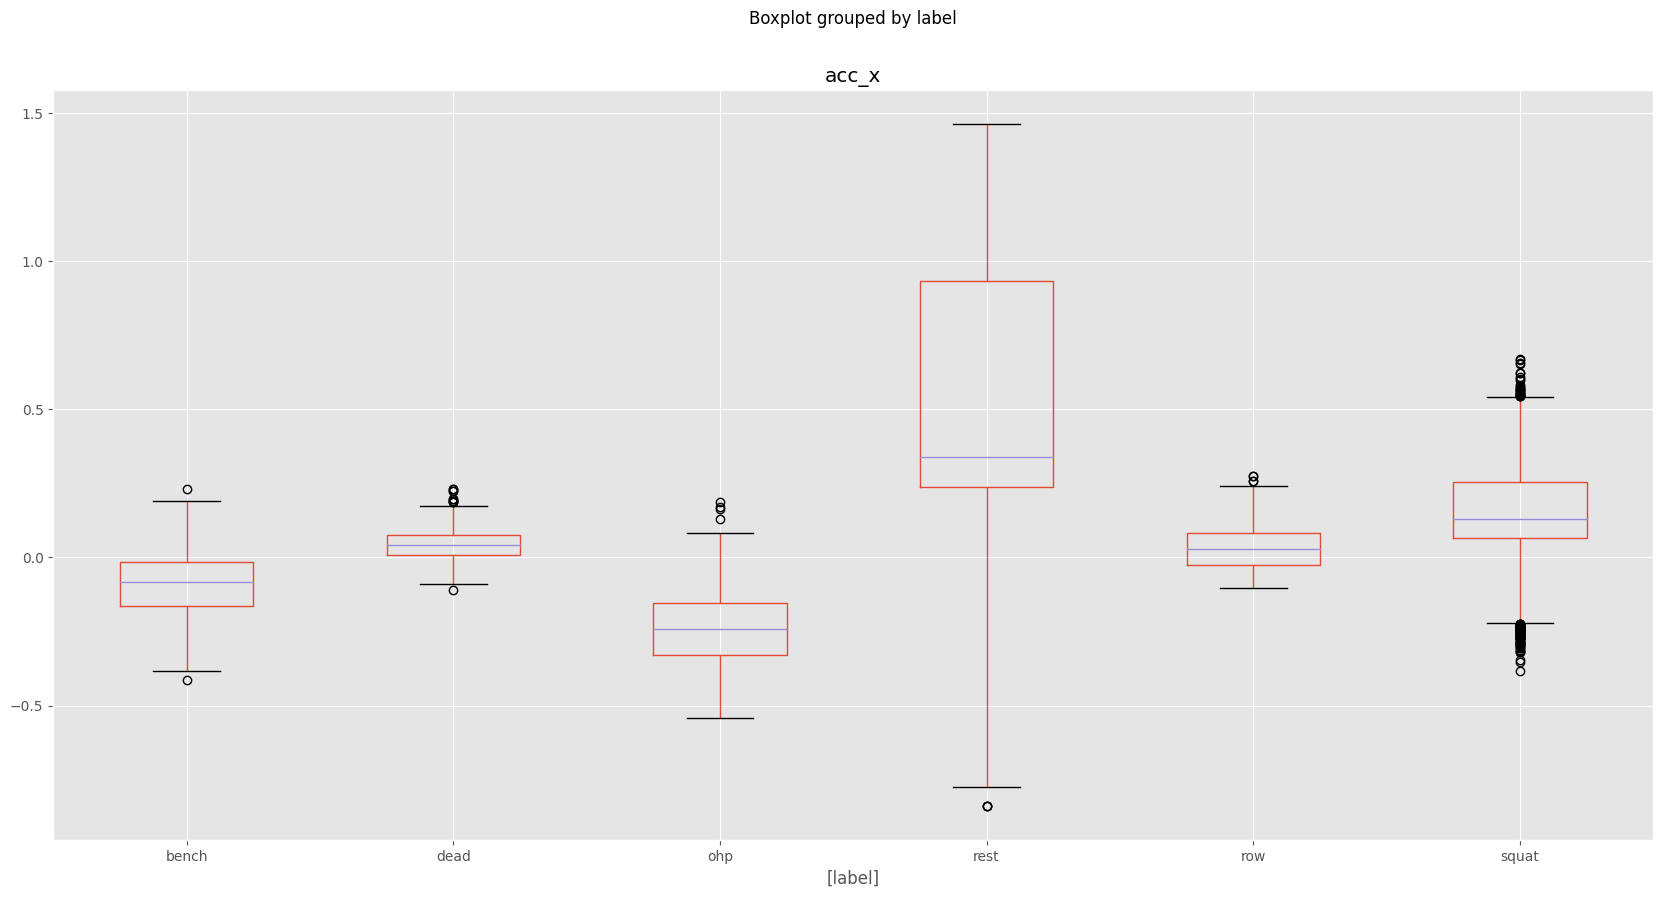

In [4]:
df[["acc_x", "label"]].boxplot(by="label", figsize=(20, 10))


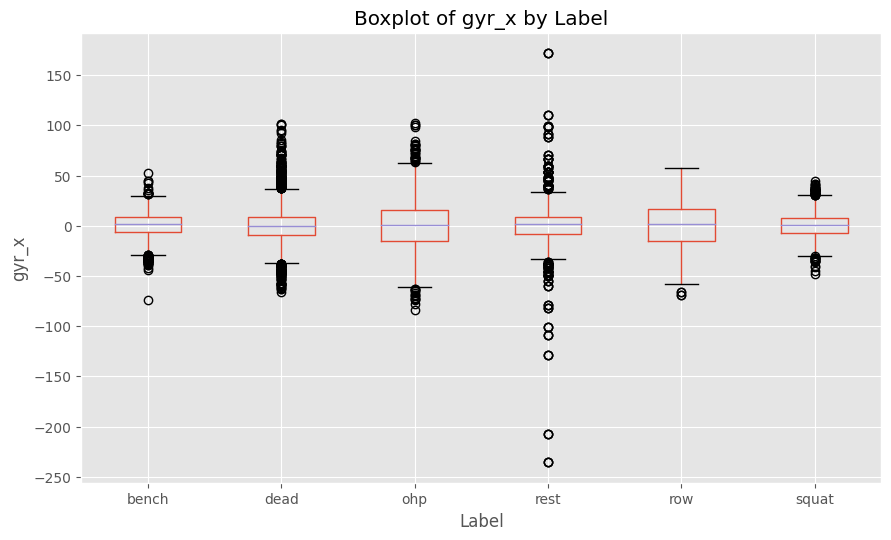

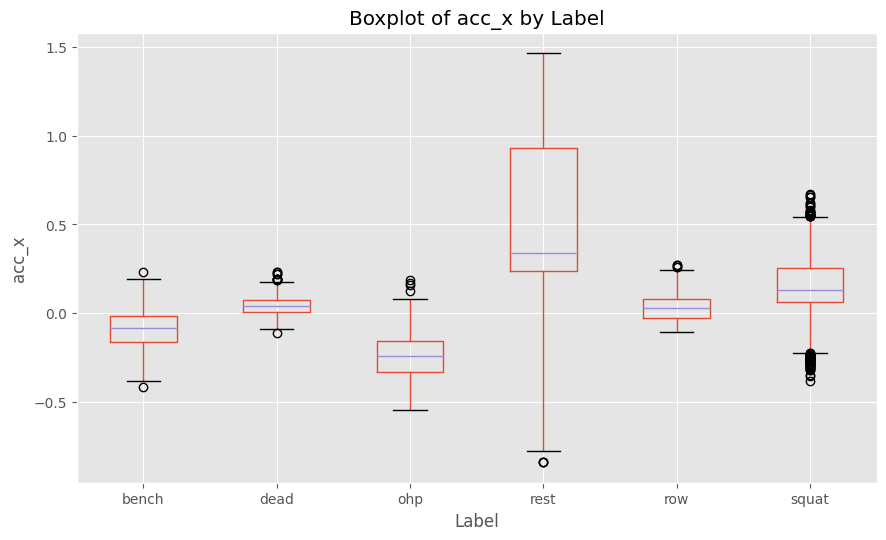

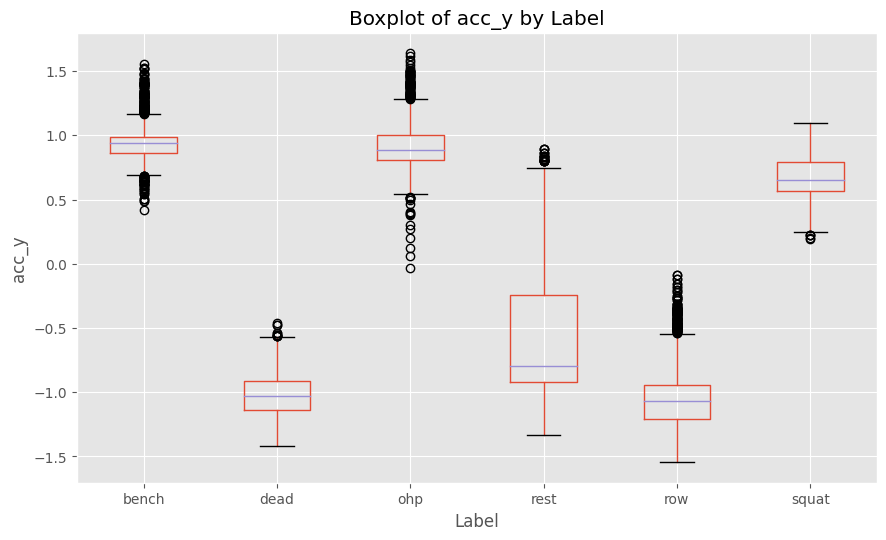

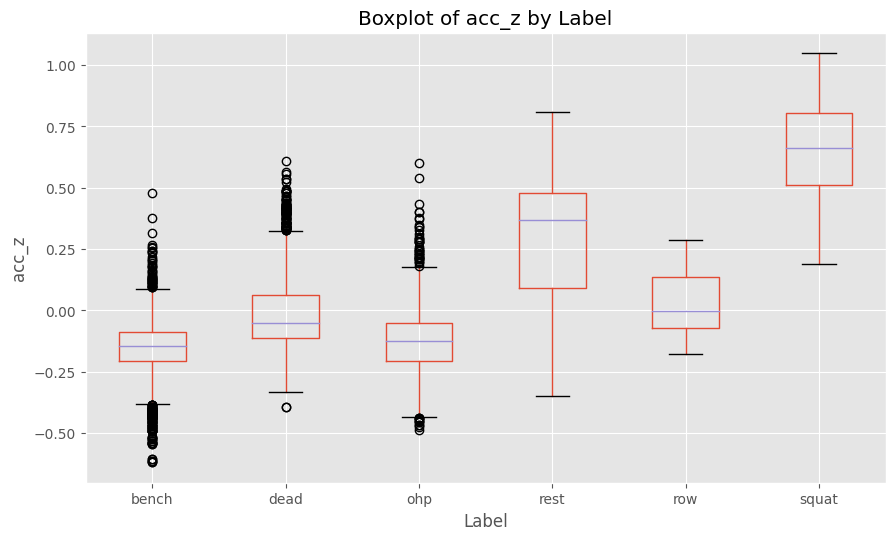

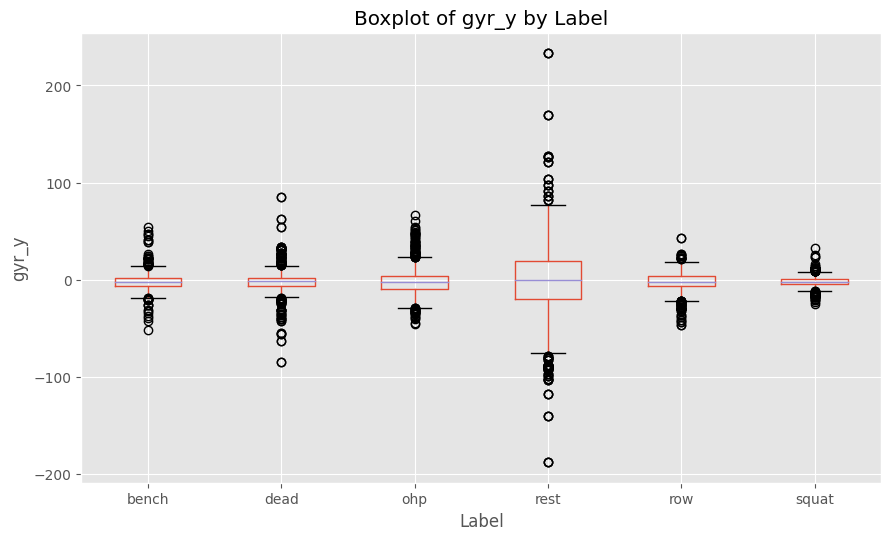

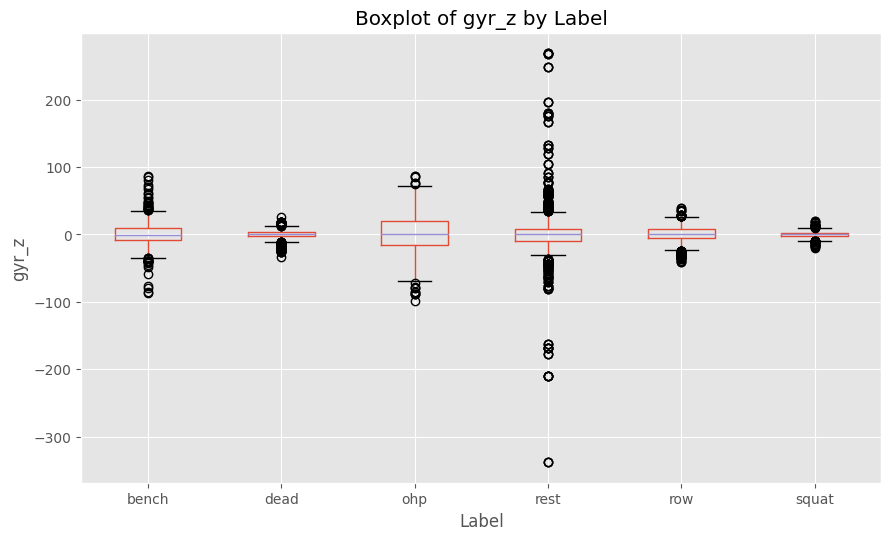

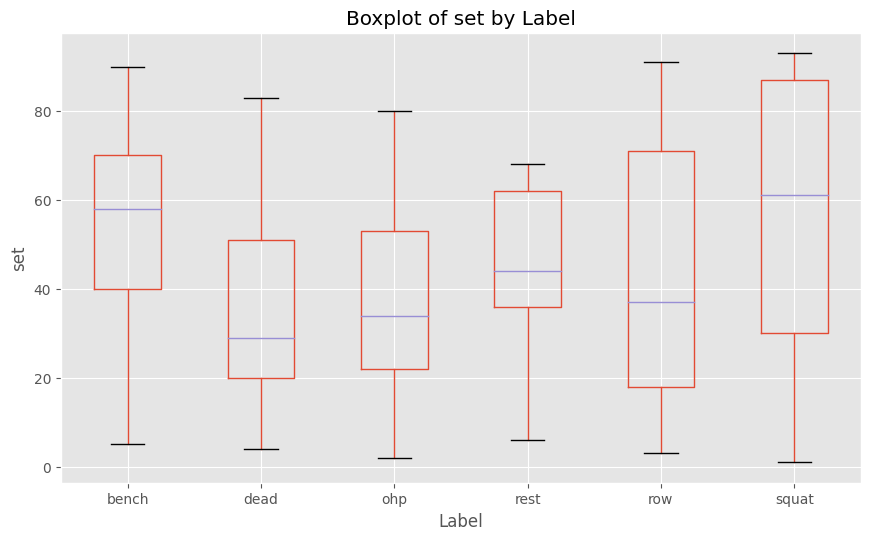

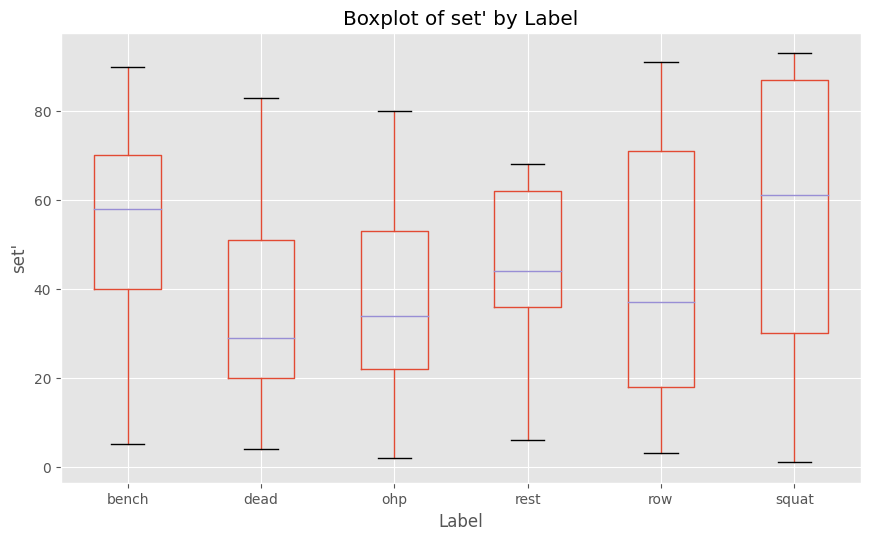

In [5]:

for col in df.columns.drop("label"):
    if df[col].dtype in ["float64", "int64"]:
        df[[col, "label"]].boxplot(by="label", figsize=(10, 6))
        plt.title(f"Boxplot of {col} by Label")
        plt.suptitle("")
        plt.xlabel("Label")
        plt.ylabel(col)
        plt.show()

array([<AxesSubplot: title={'center': 'gyr_x'}, xlabel='[label]'>,
       <AxesSubplot: title={'center': 'gyr_y'}, xlabel='[label]'>,
       <AxesSubplot: title={'center': 'gyr_z'}, xlabel='[label]'>],
      dtype=object)

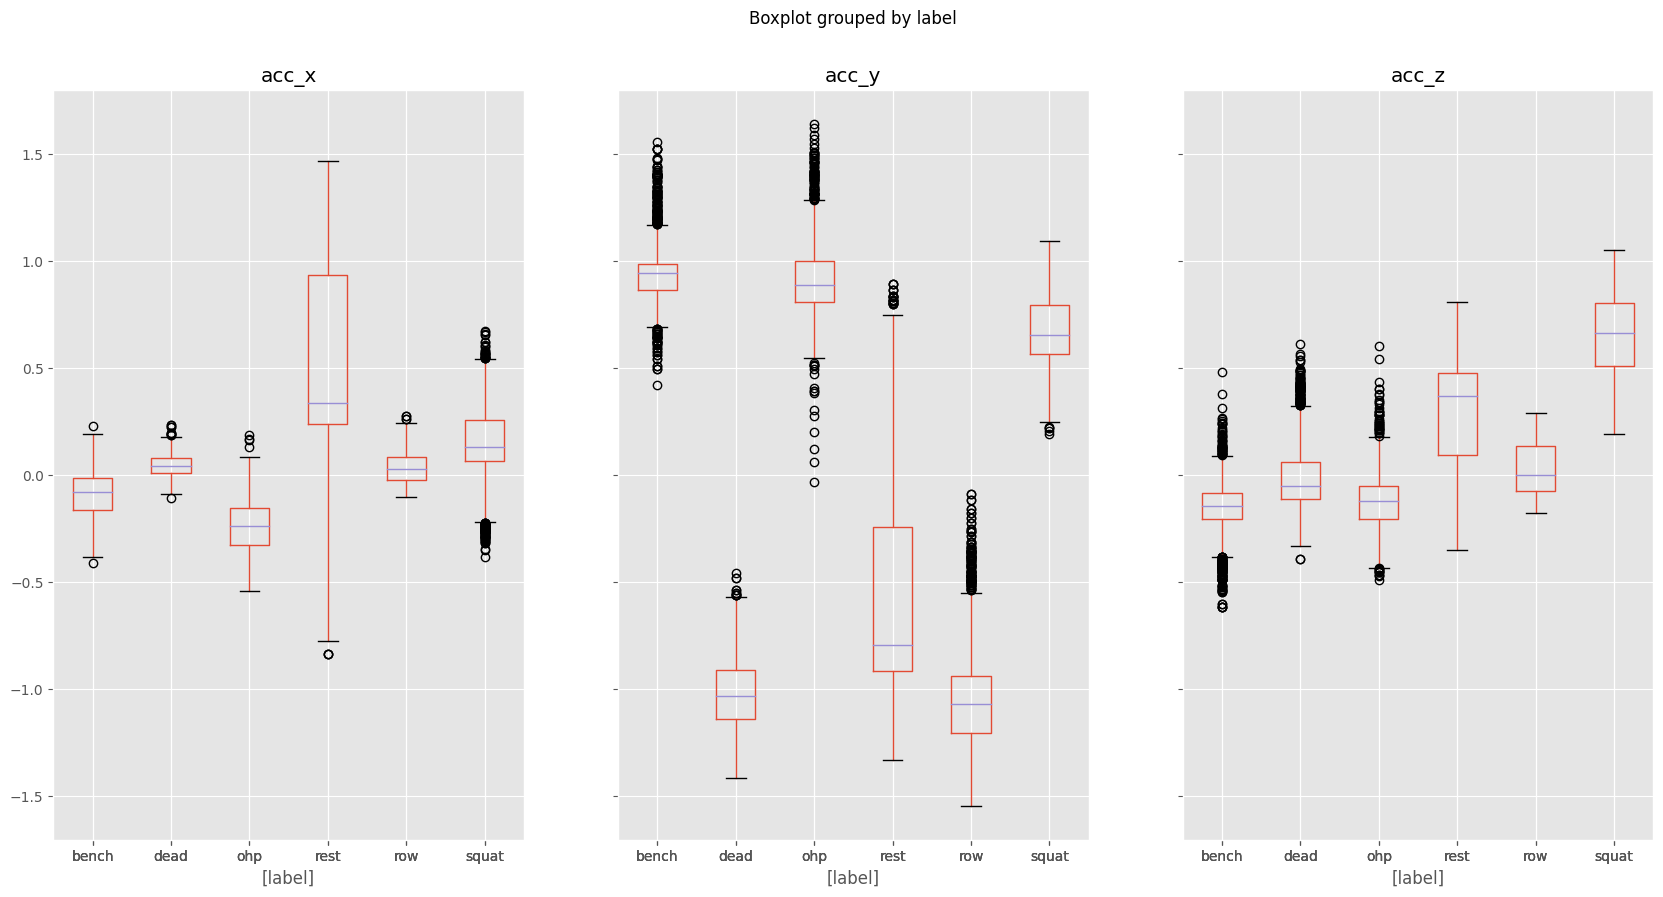

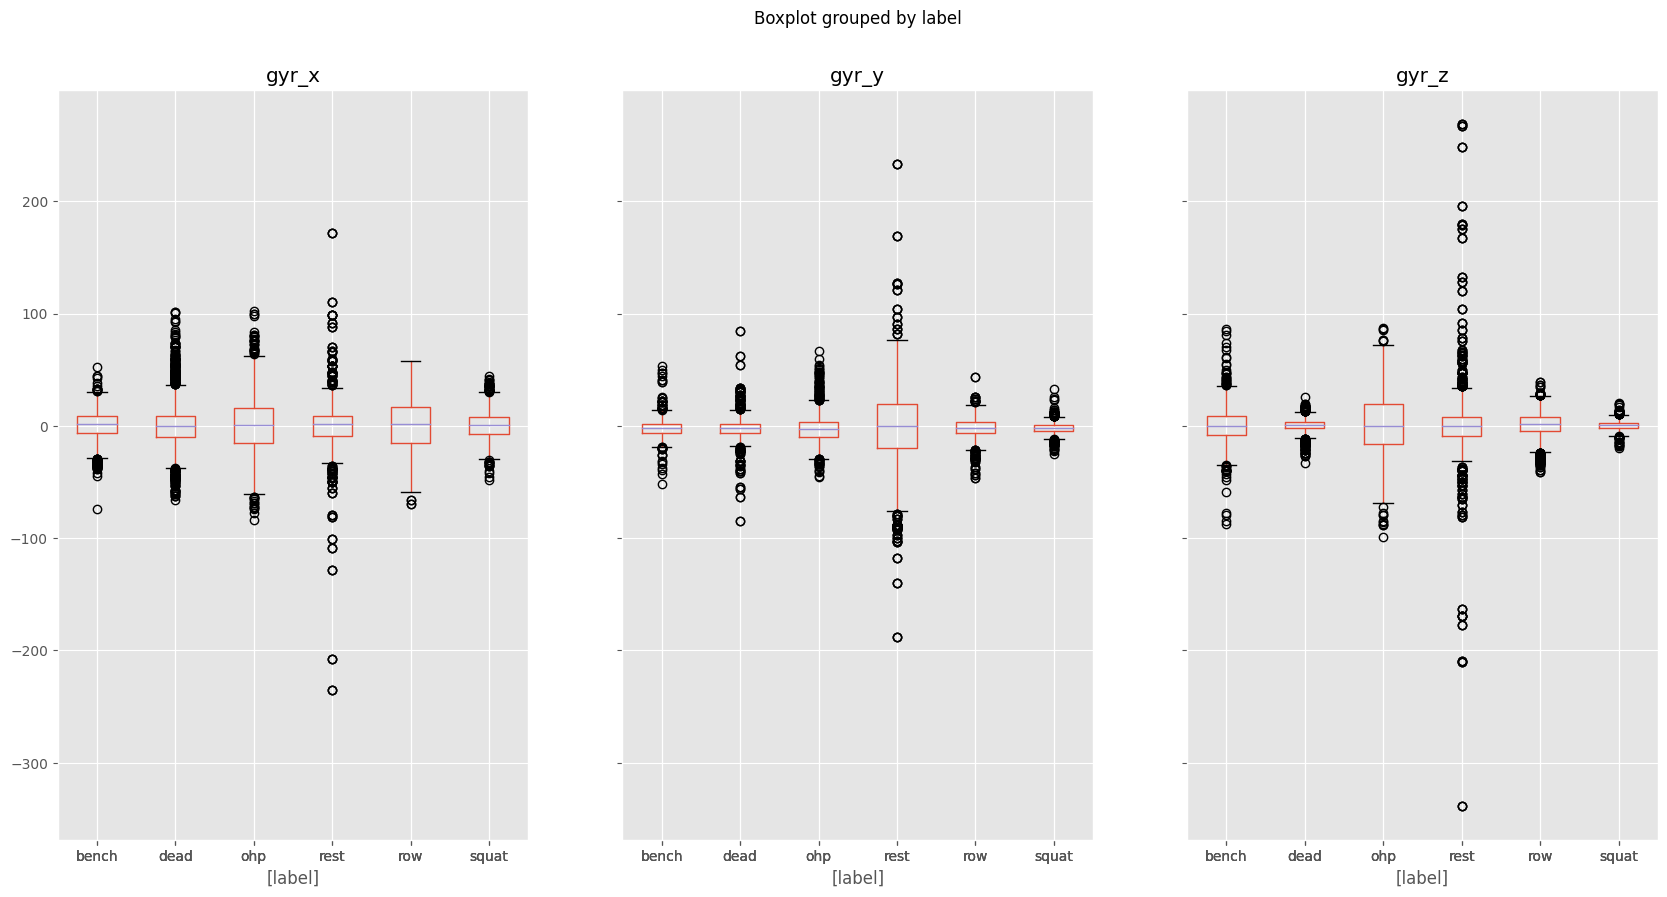

In [7]:


outlier_columns = sorted(df.columns[0:6].tolist())

df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))

array([[<AxesSubplot: title={'center': 'bench'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'dead'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<AxesSubplot: title={'center': 'rest'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'row'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'squat'}, ylabel='Frequency'>],
       [<AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>]], dtype=object)

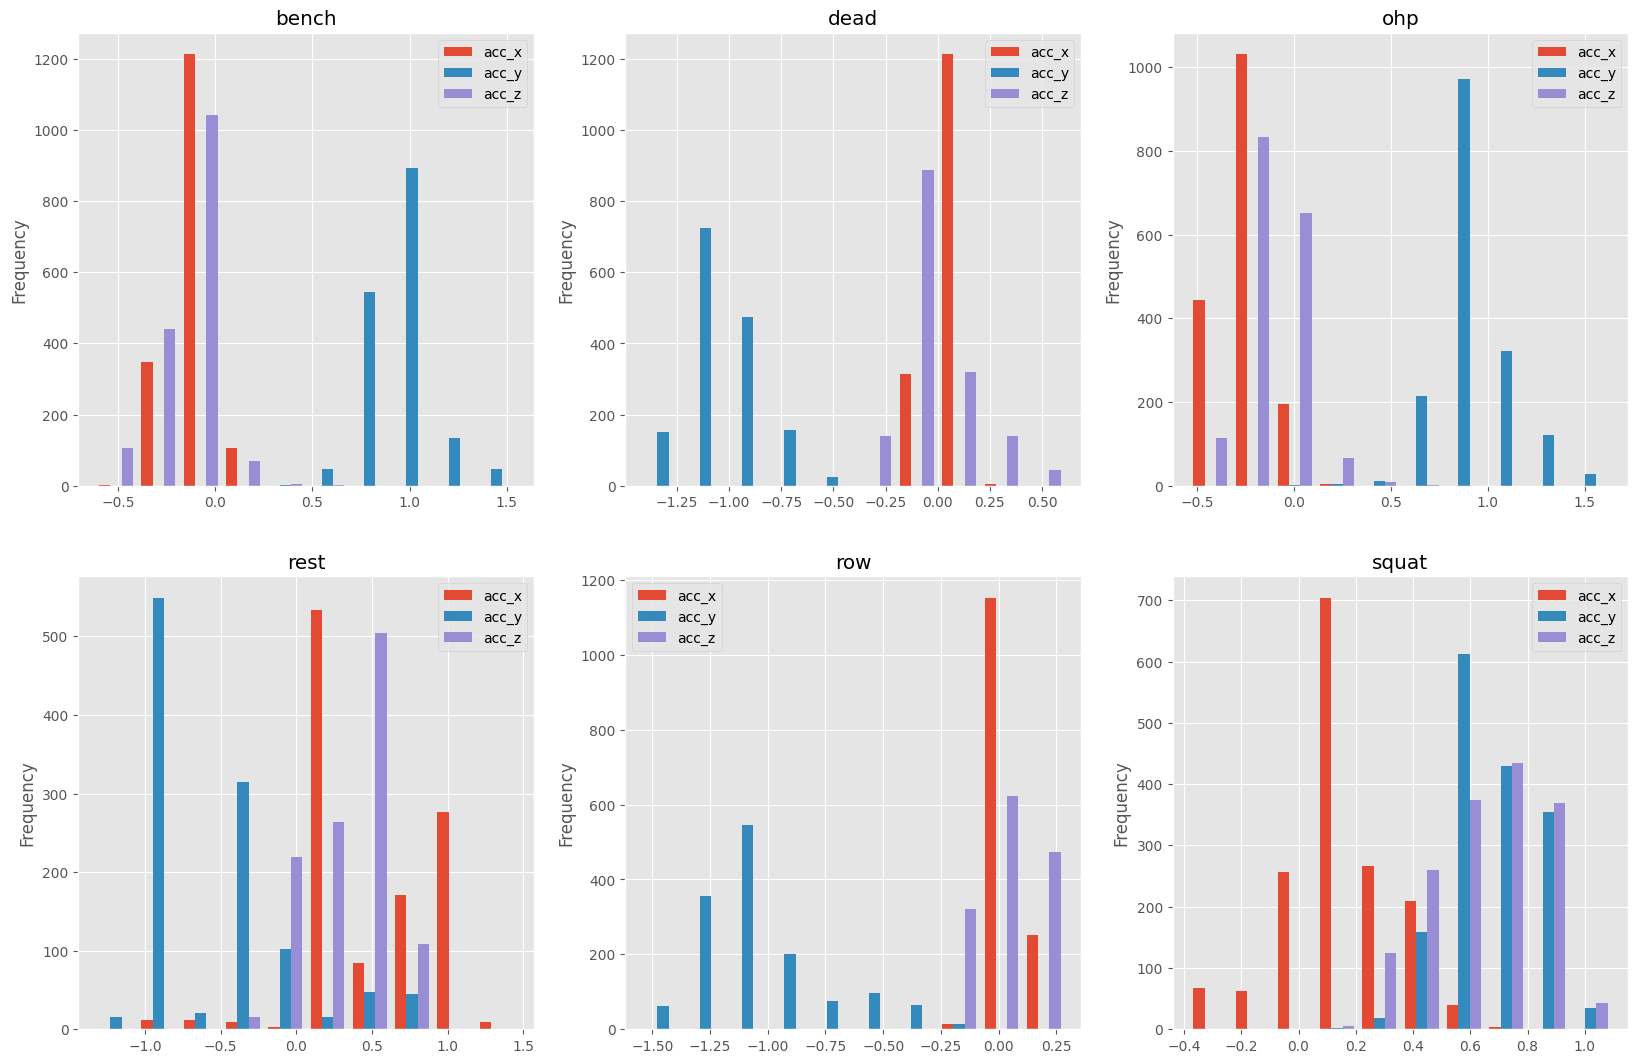

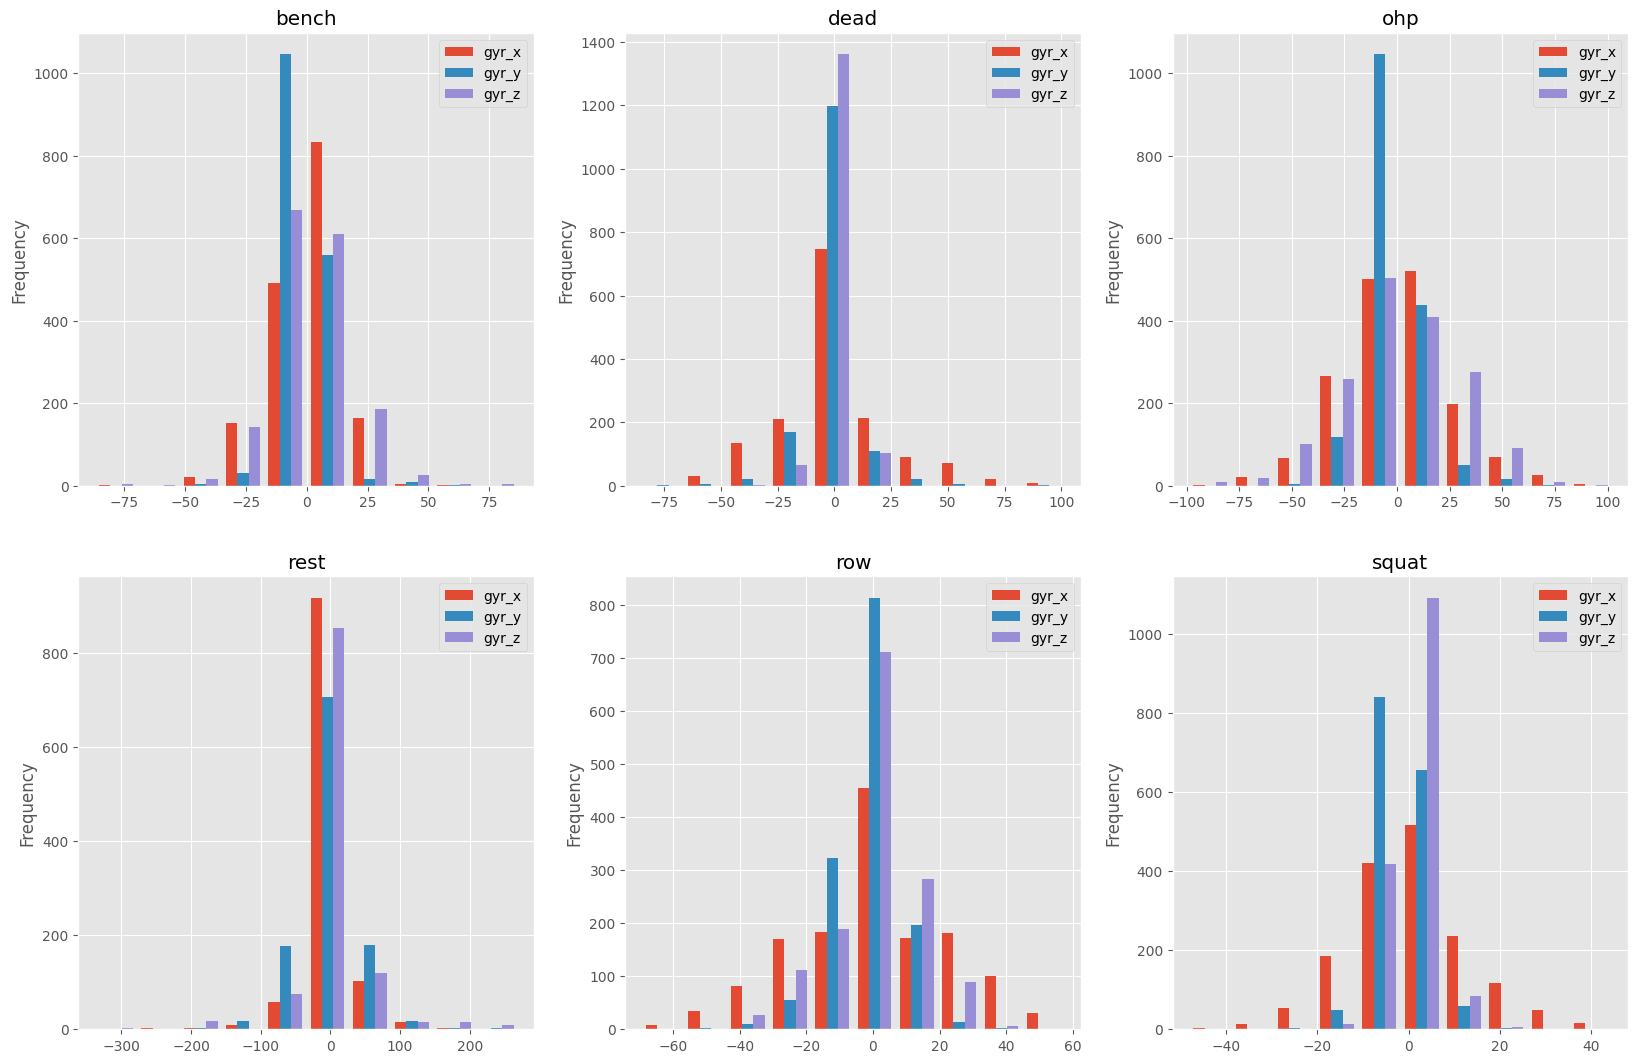

In [ ]:

# -----------------------------------------------------------
# Histograms
# -----------------------------------------------------------


df[outlier_columns[:3] + ["label"]].plot.hist(
    by="label", figsize=(20, 20), layout=(3, 3)
)
df[outlier_columns[3:] + ["label"]].plot.hist(by="label", figsize=(20, 20), layout=(3, 3))

In [9]:

# -----------------------------------------------------------
# IQR Method
# -----------------------------------------------------------


def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "g+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()


def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset


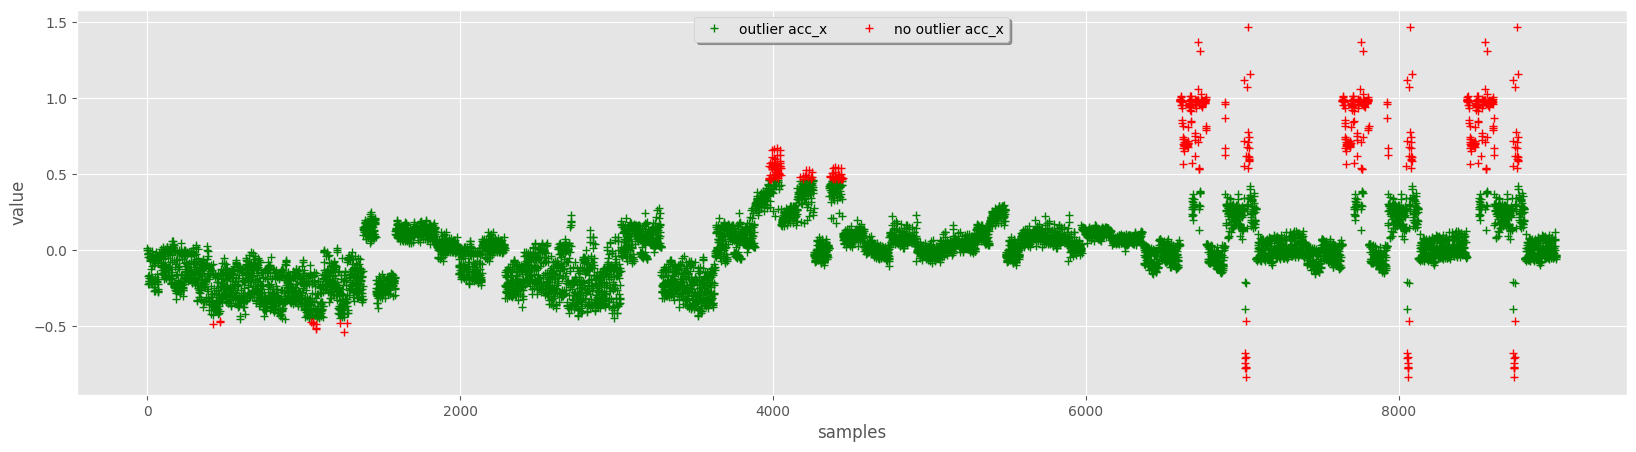

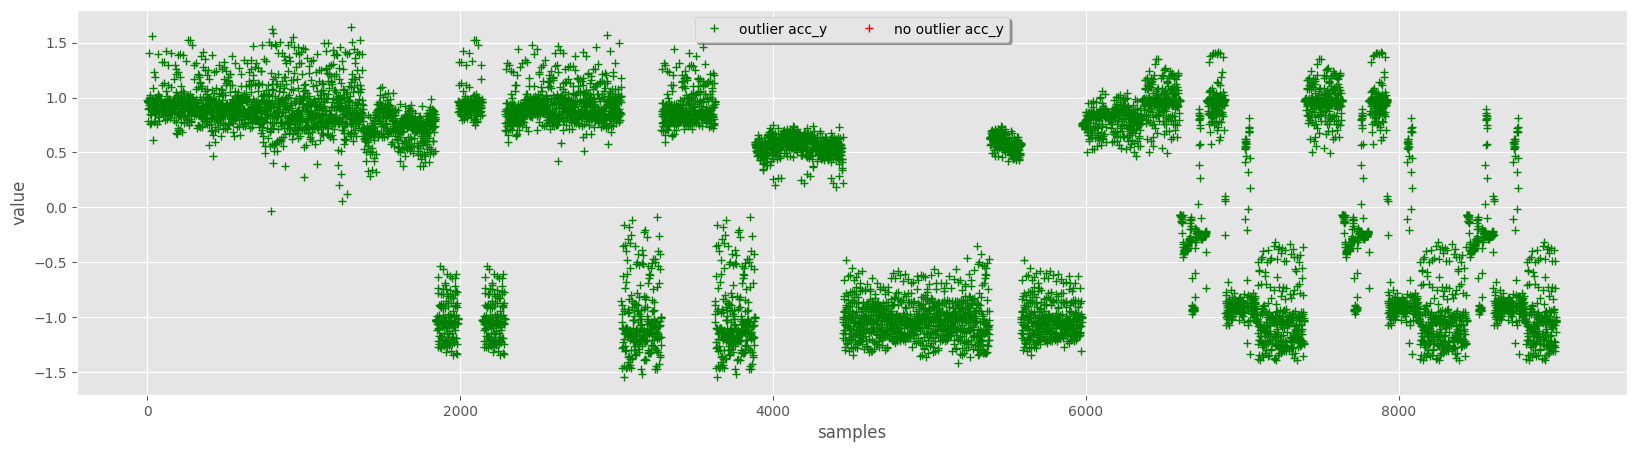

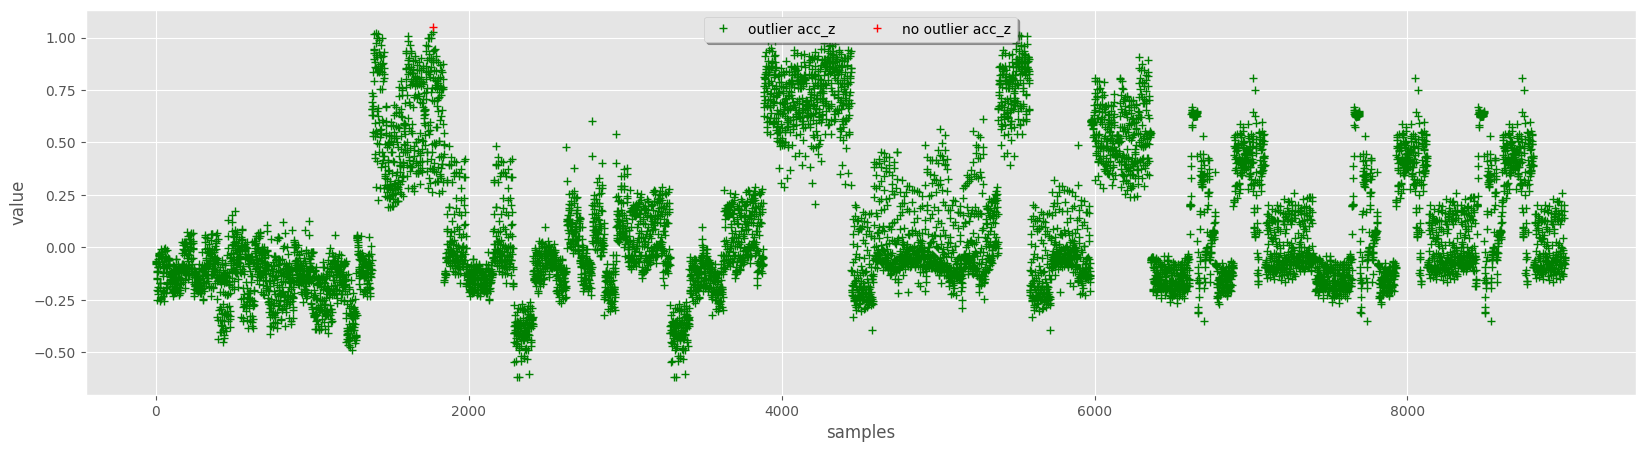

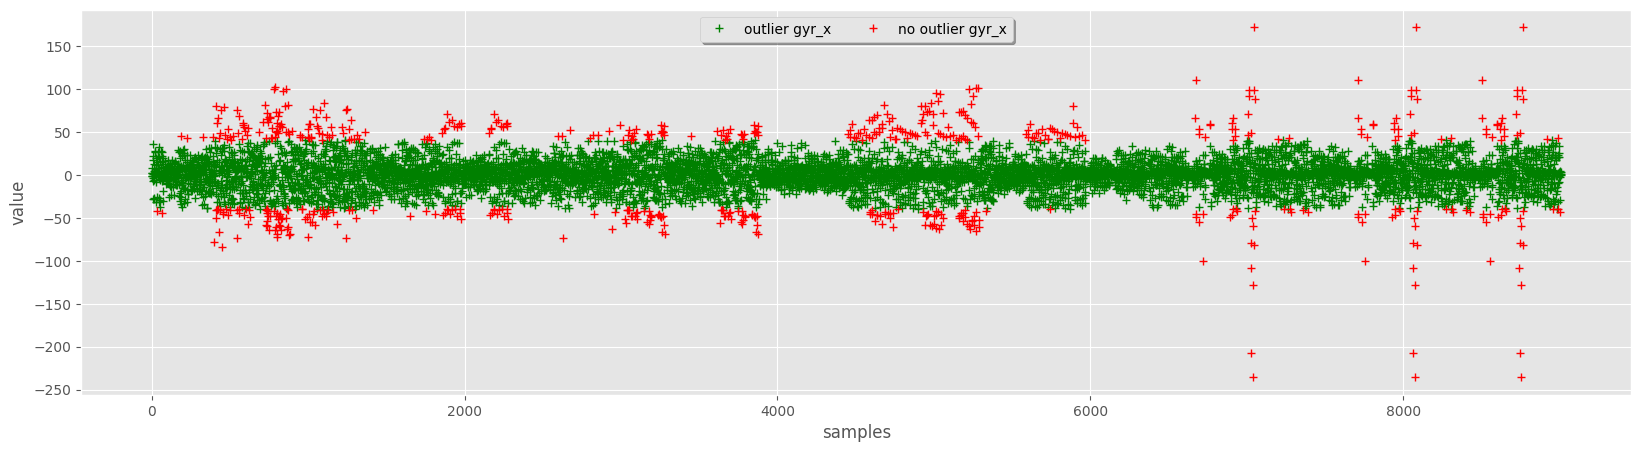

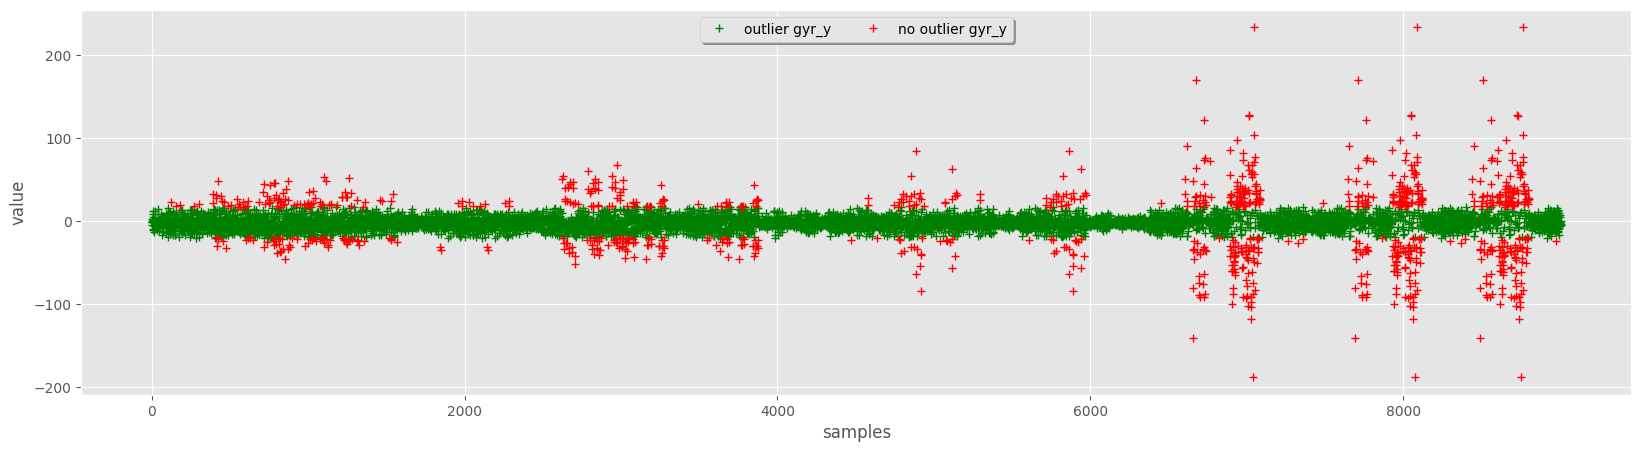

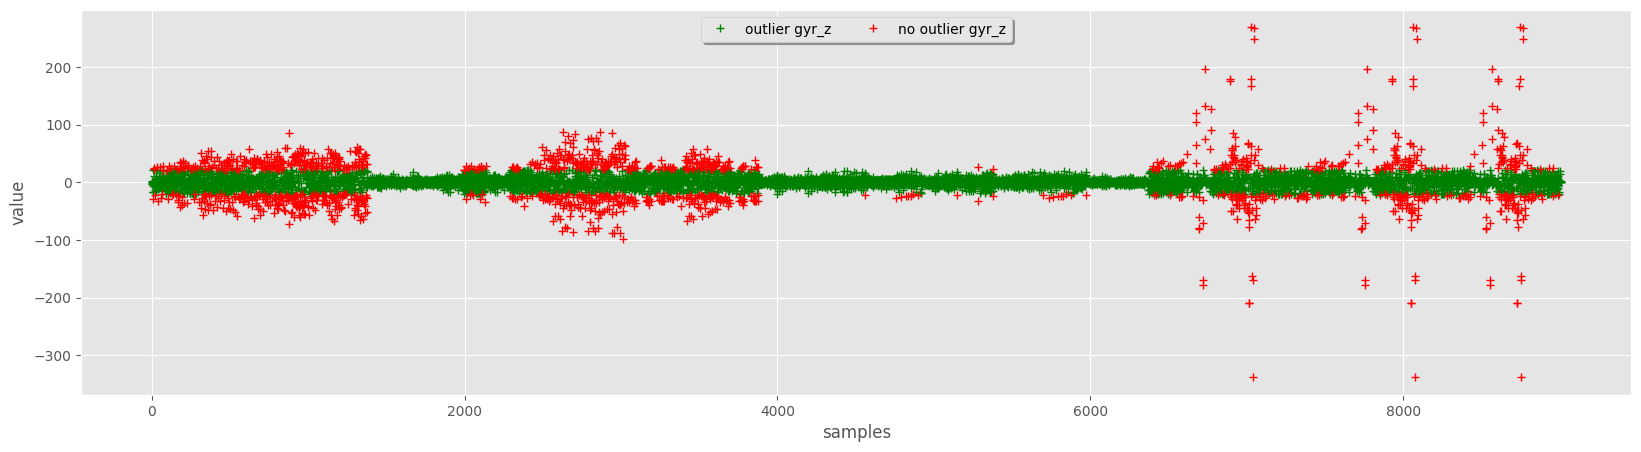

In [10]:

for col in outlier_columns:
    dataset = mark_outliers_iqr(df, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

In [11]:

# -----------------------------------------------------------
# Chauvenets criterion
# -----------------------------------------------------------

import math
import scipy


def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.

    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset



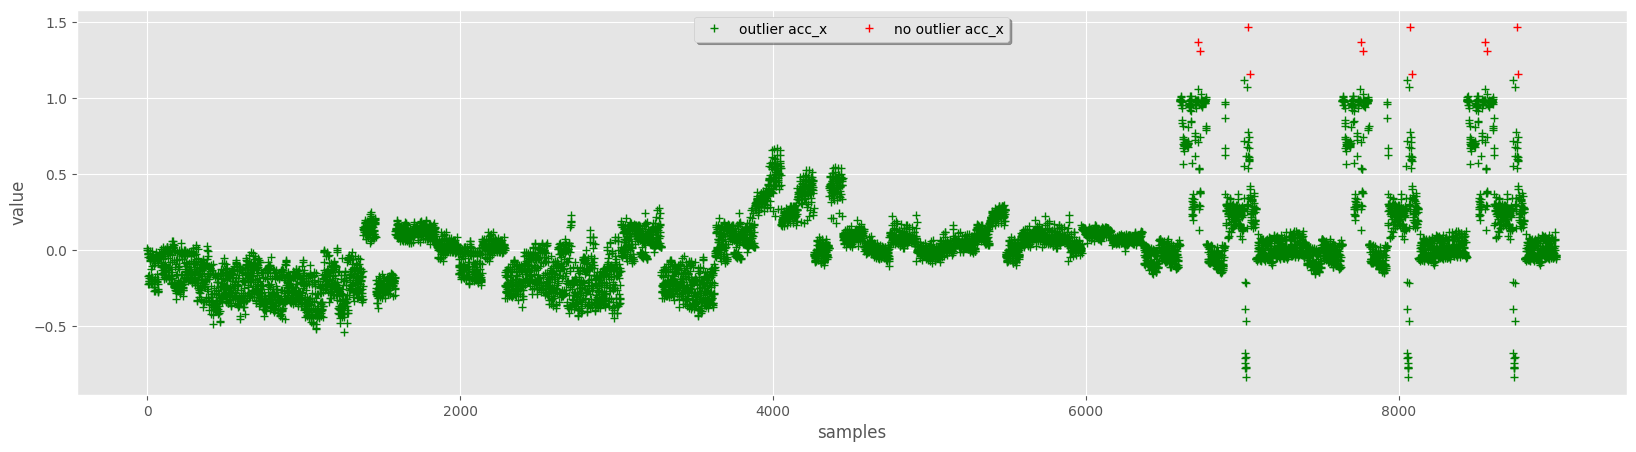

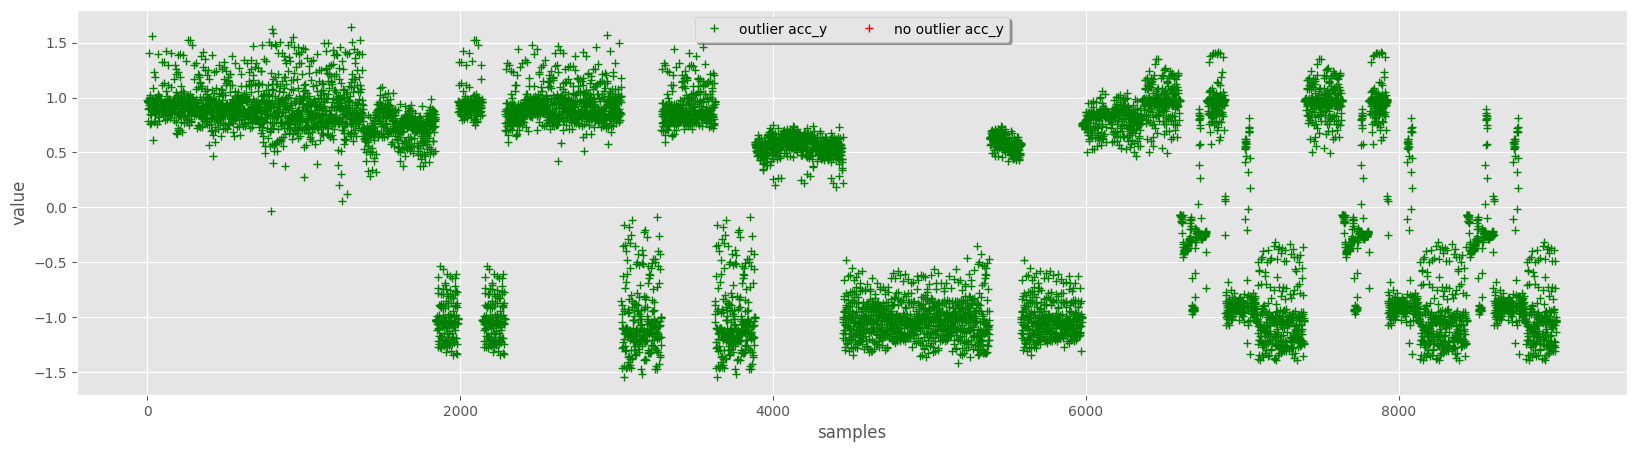

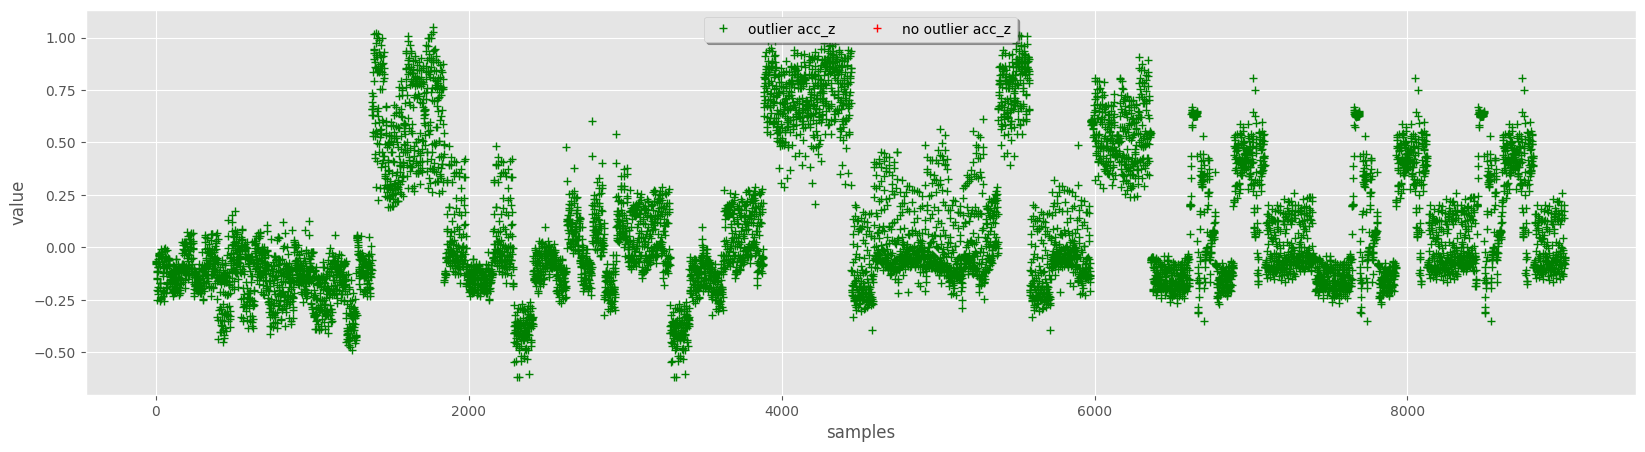

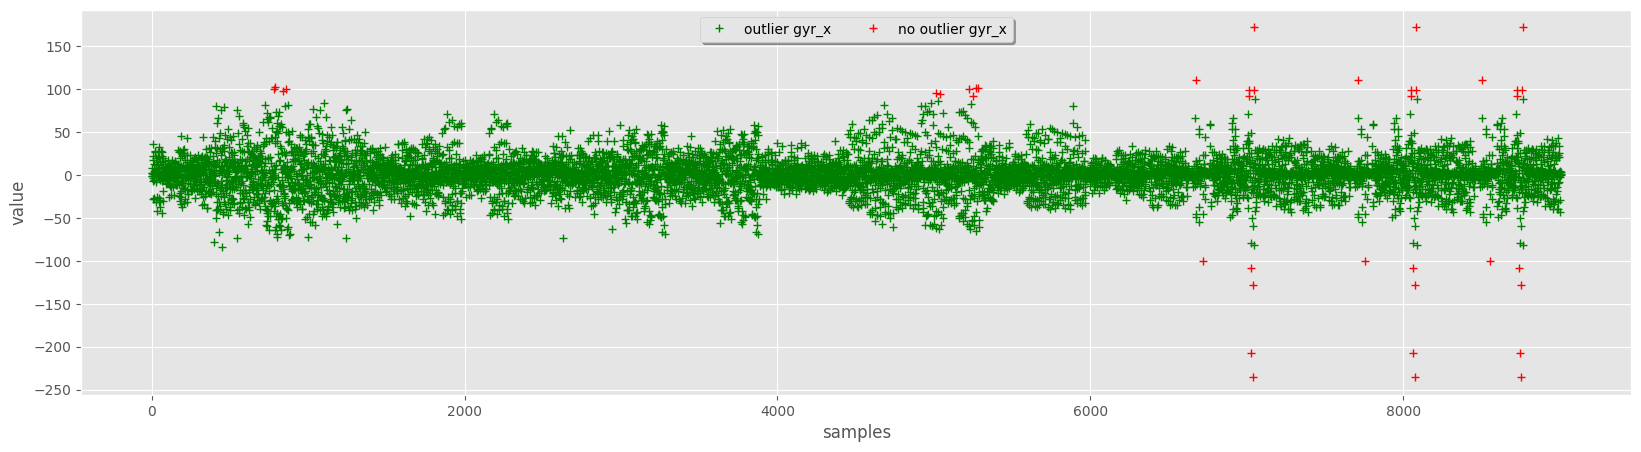

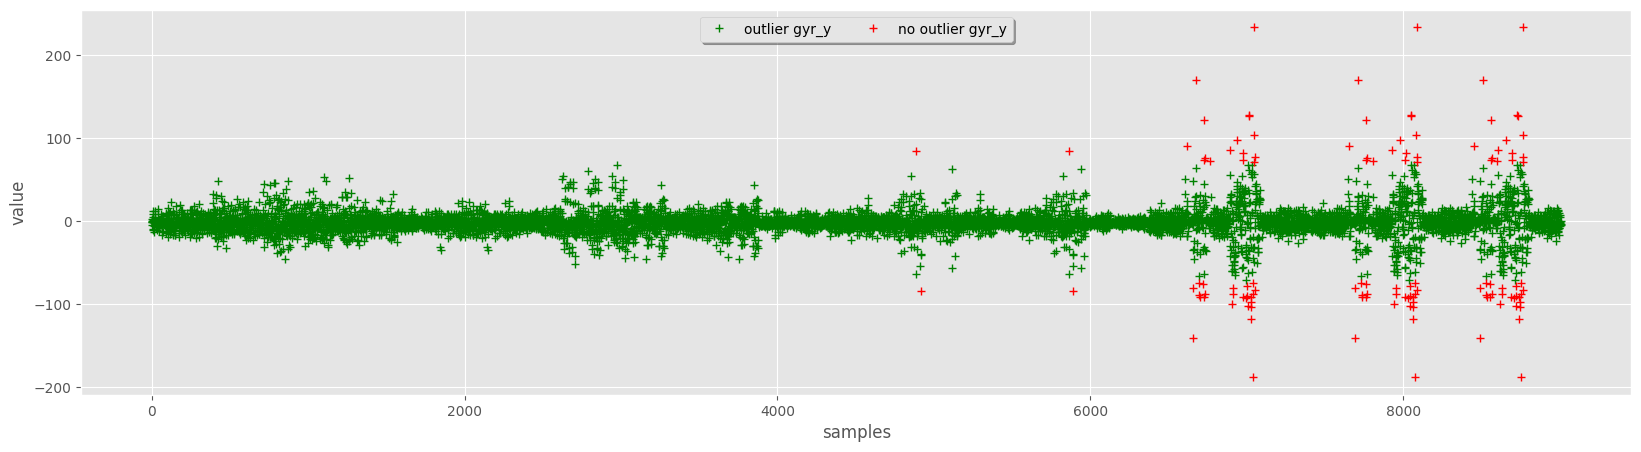

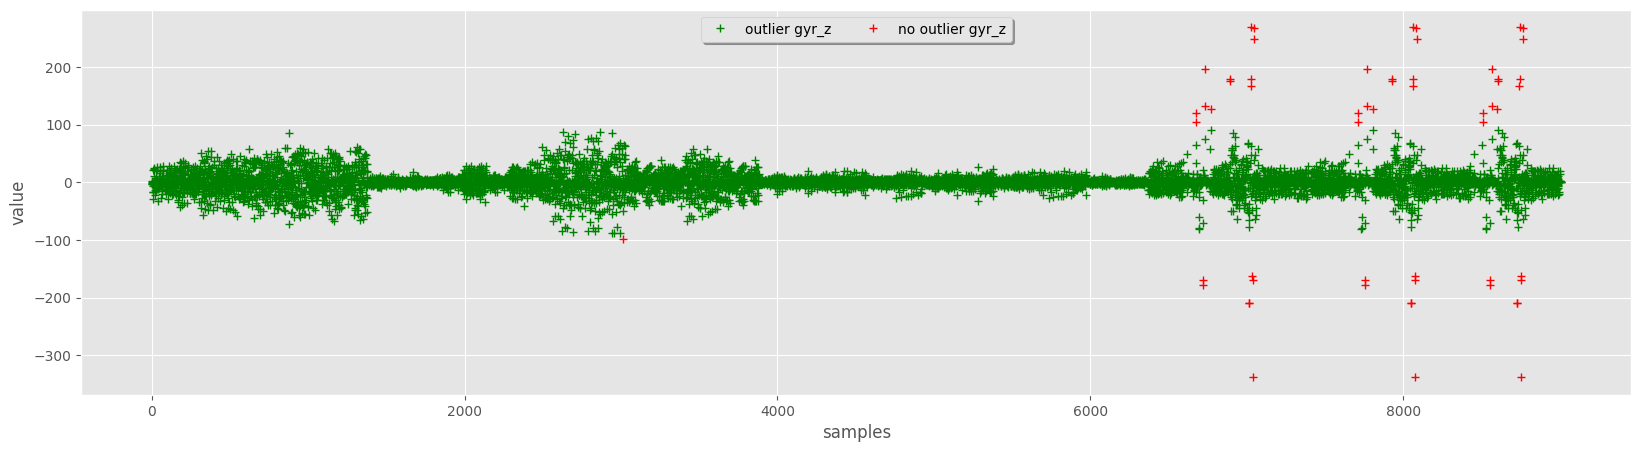

In [12]:


for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

In [13]:

# -----------------------------------------------------------
# Local Outliers
# -----------------------------------------------------------


def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores


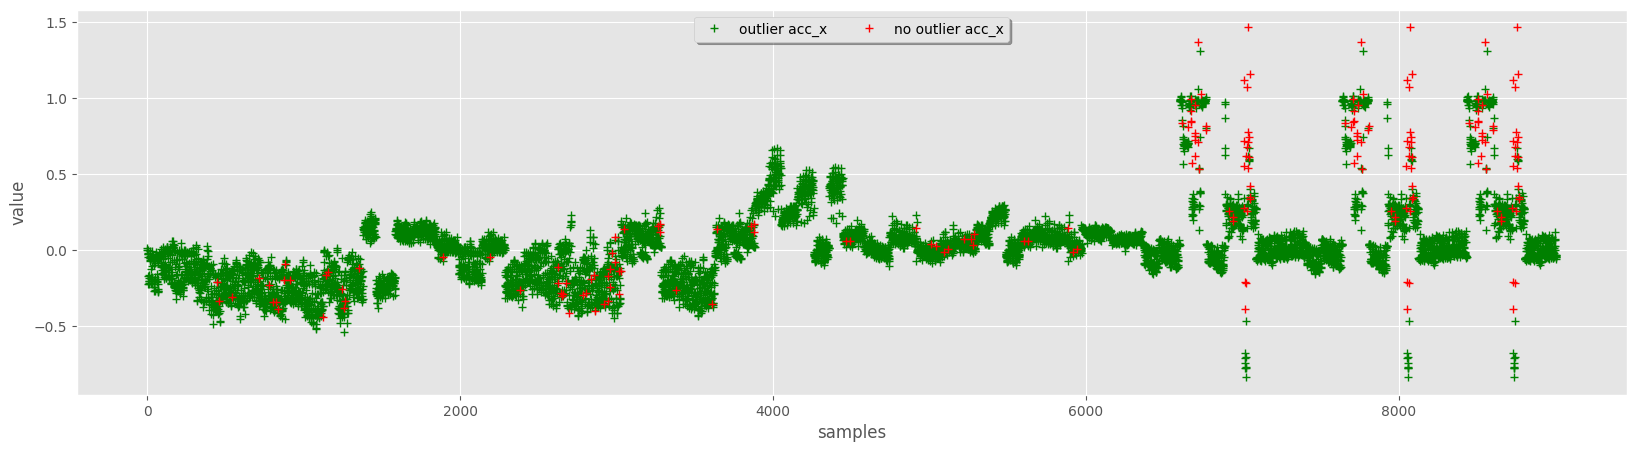

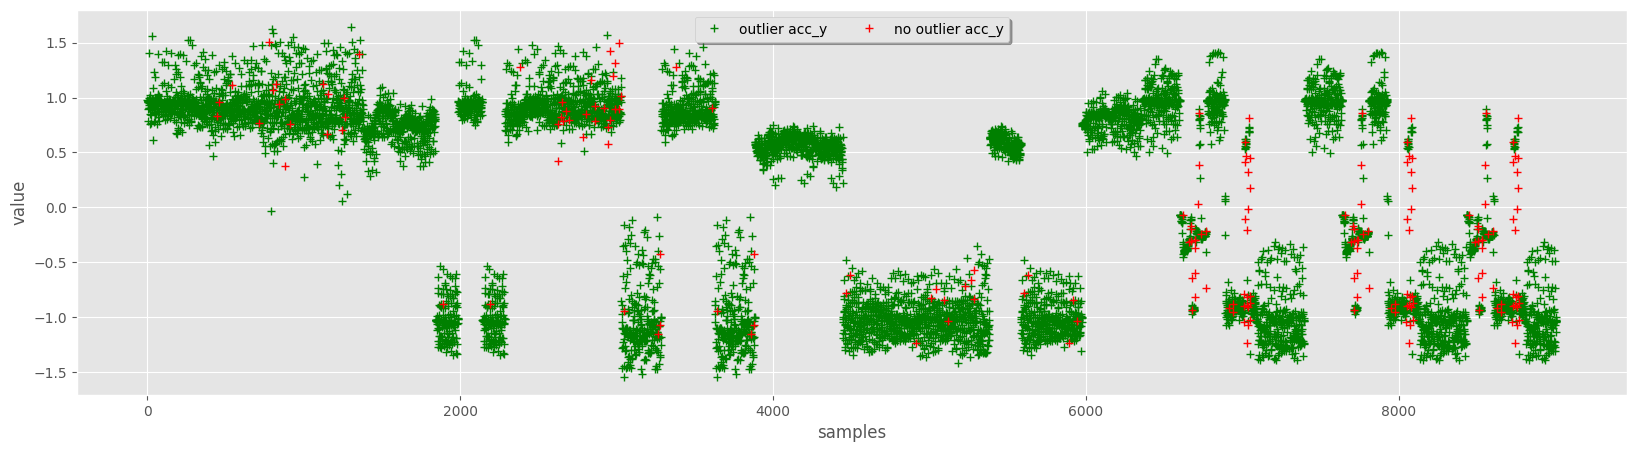

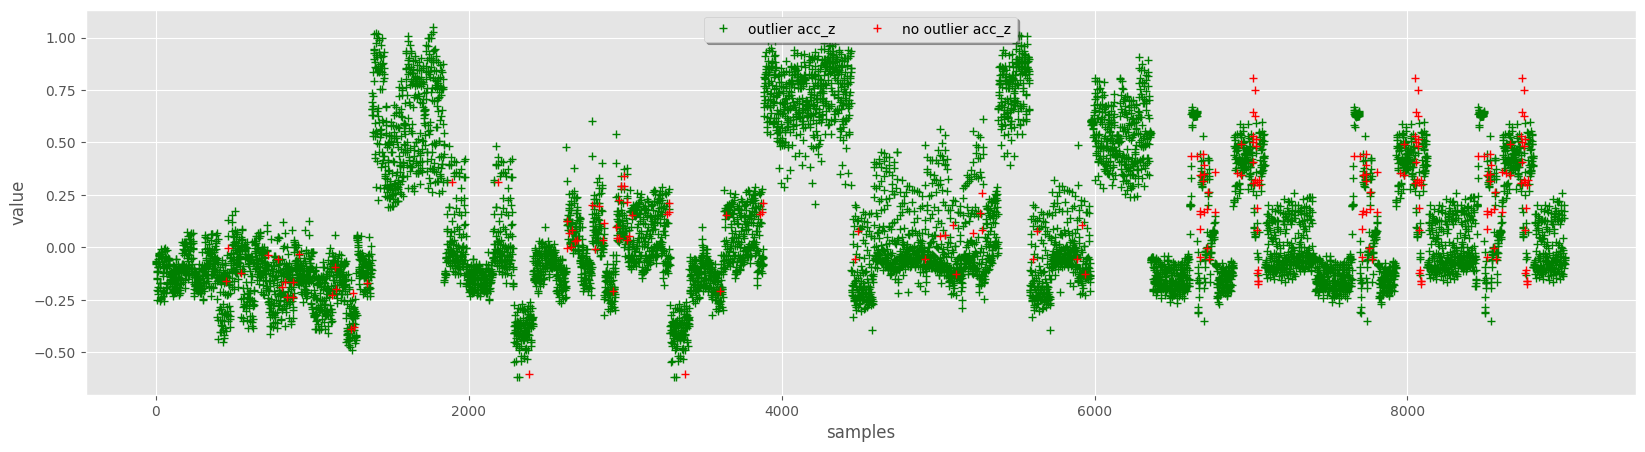

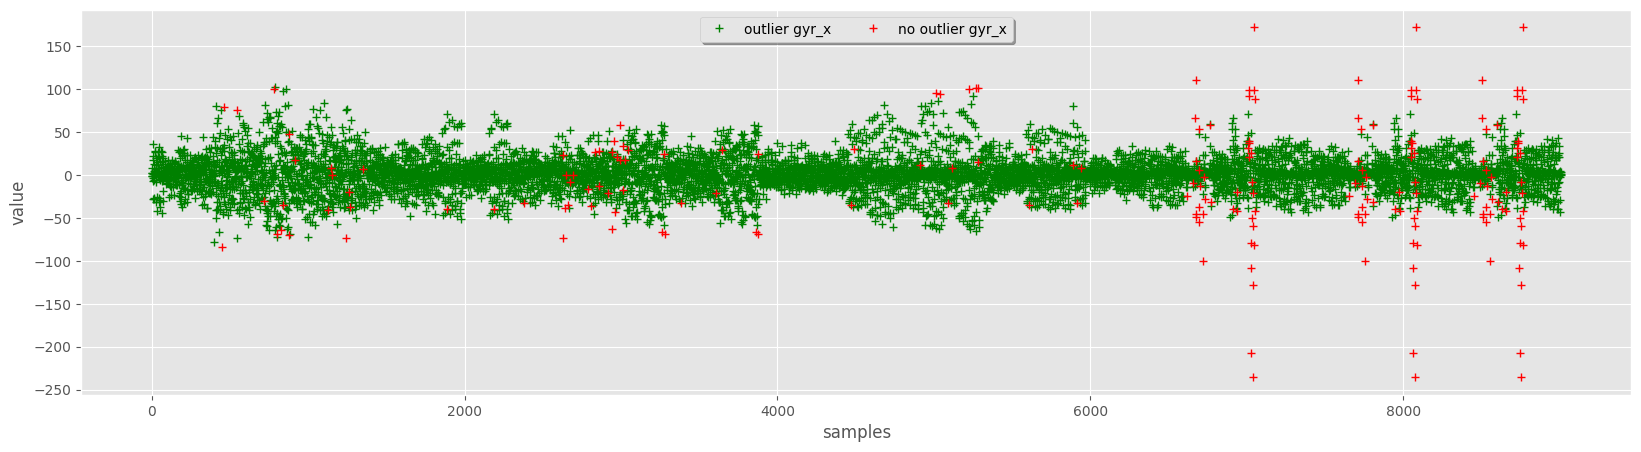

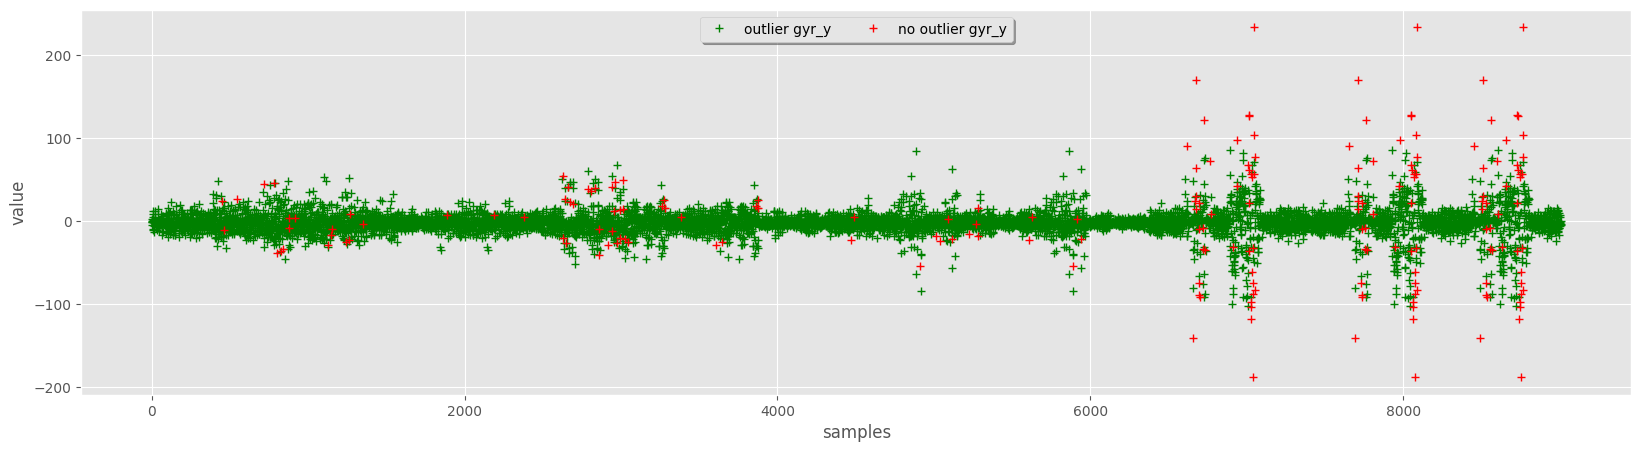

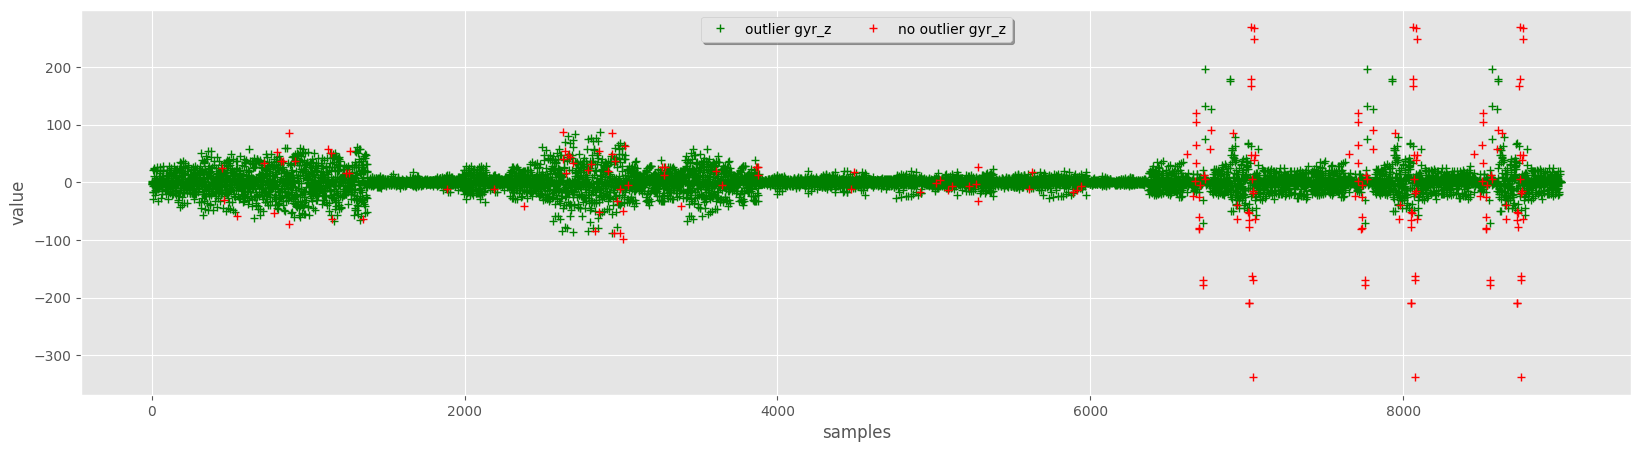

In [14]:

dataset, outliers, X_scores = mark_outliers_lof(df, outlier_columns)
for col in outlier_columns:
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True
    )

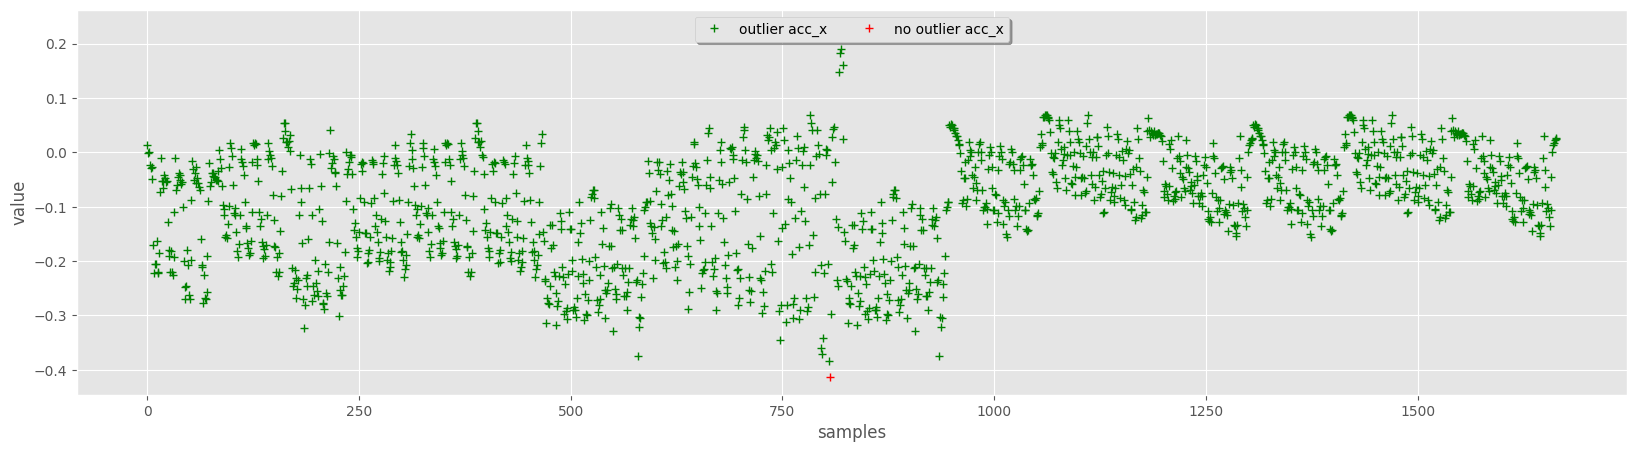

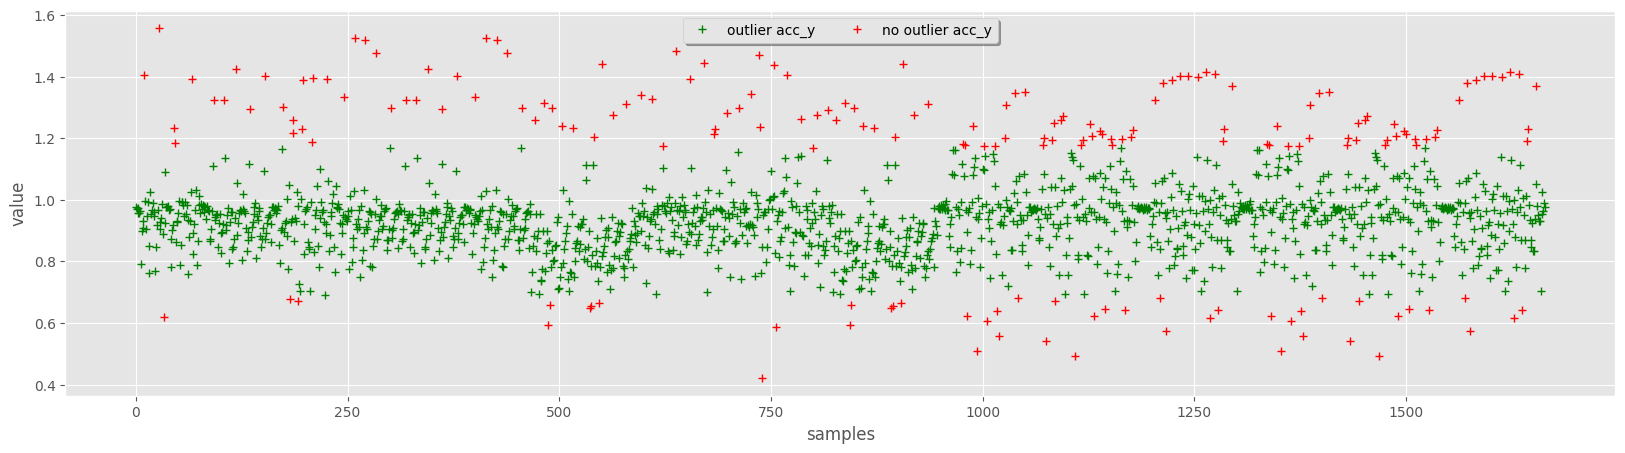

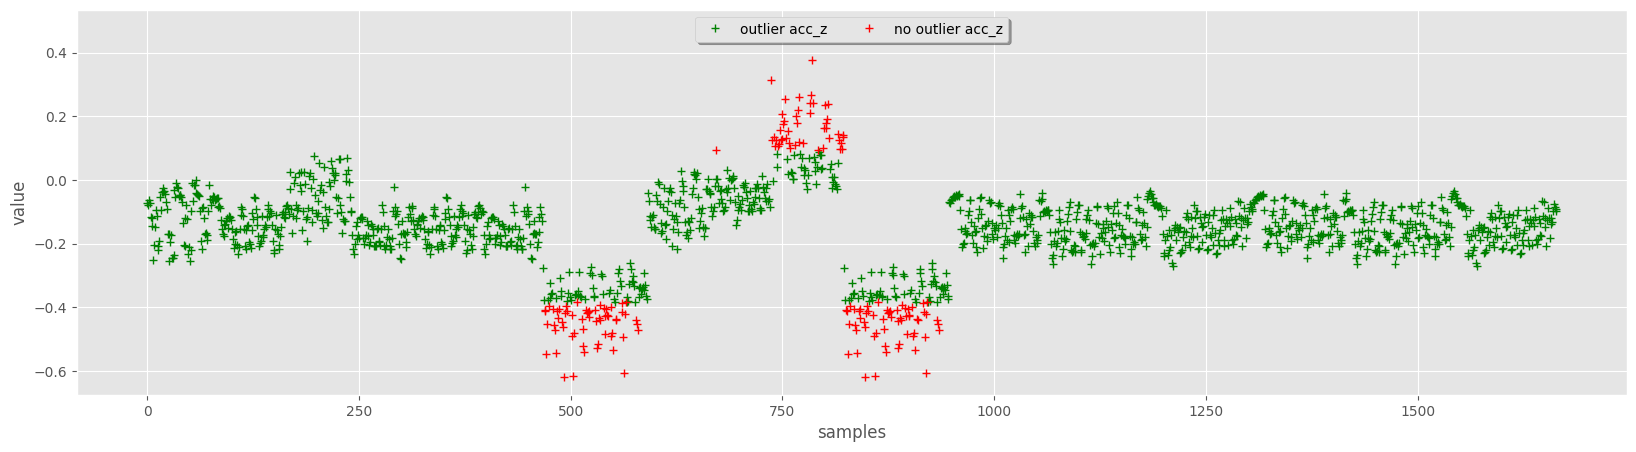

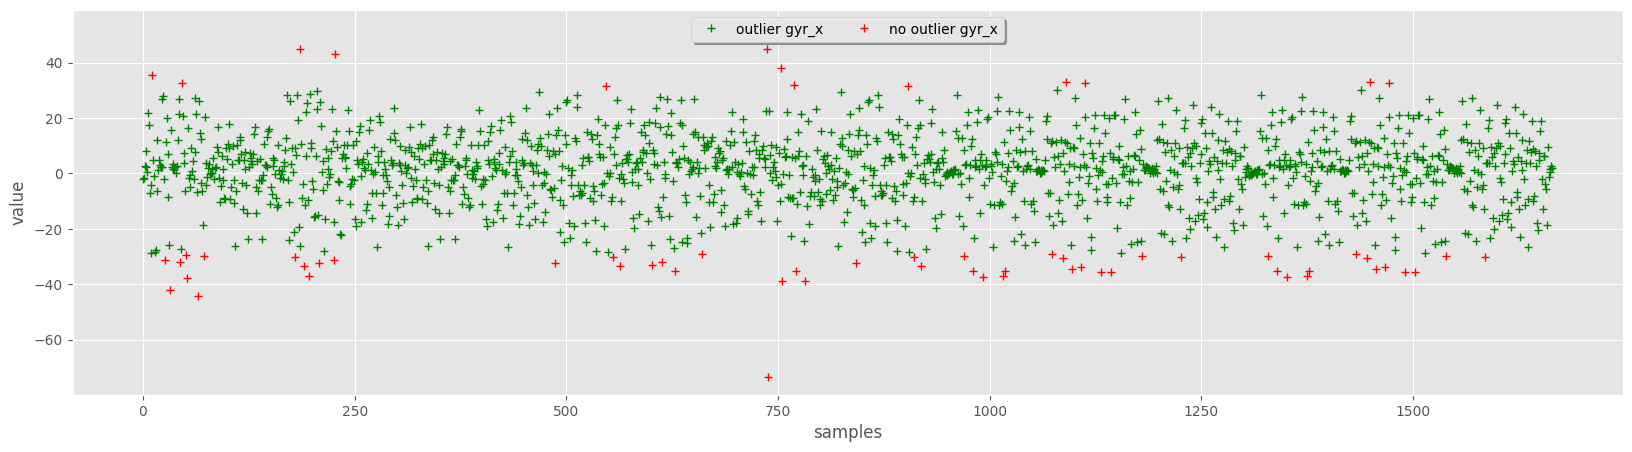

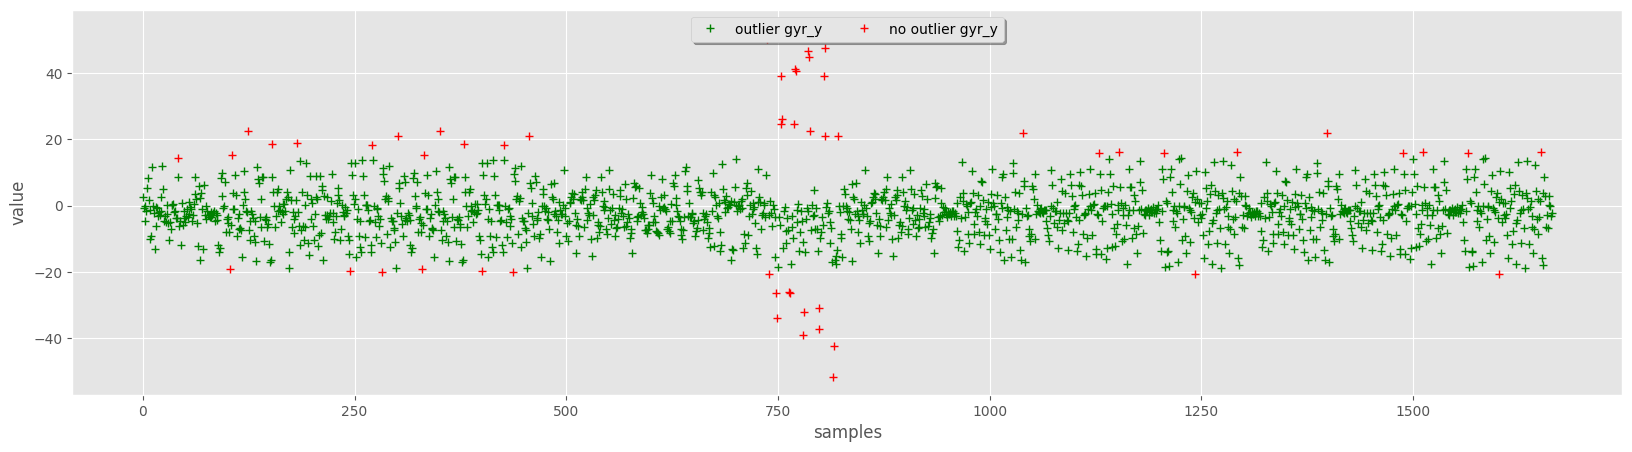

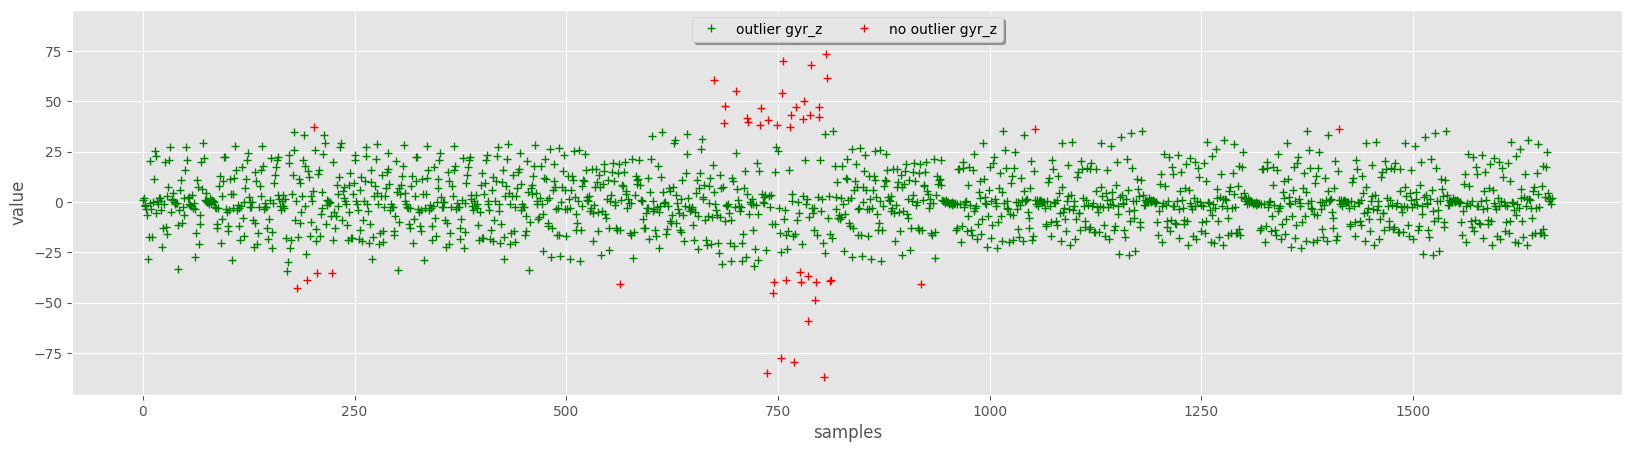

In [15]:

# -----------------------------------------------------------
# Check Oultliers grouped by label
# -----------------------------------------------------------


for col in outlier_columns:
    dataset = mark_outliers_iqr(df[df["label"] == "bench"], col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

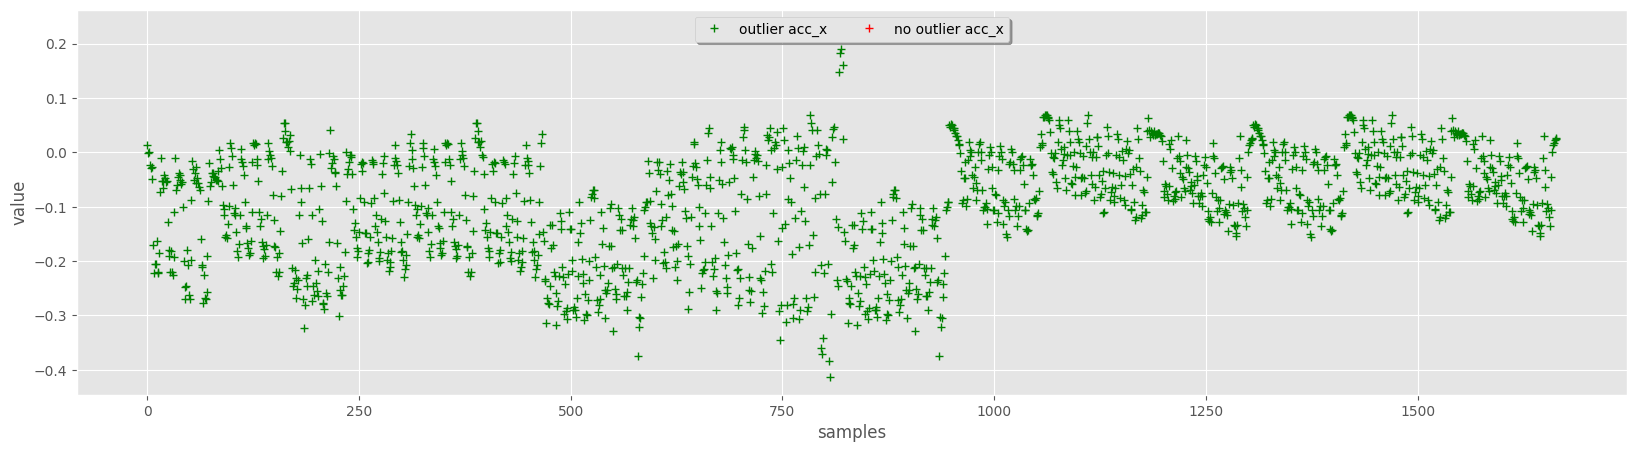

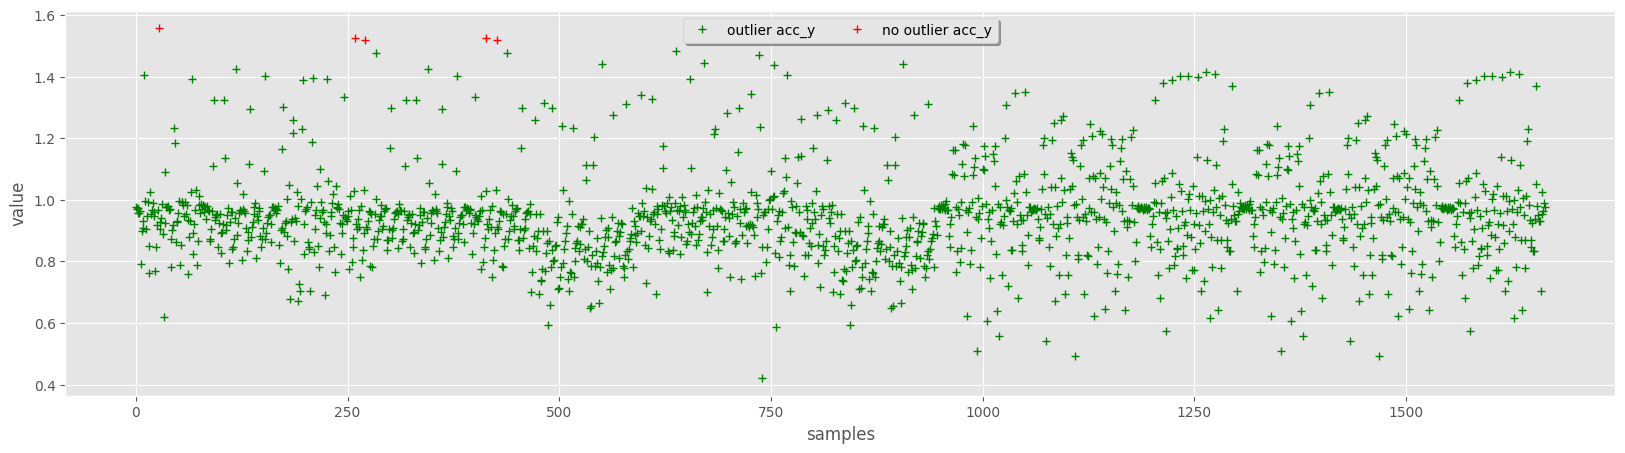

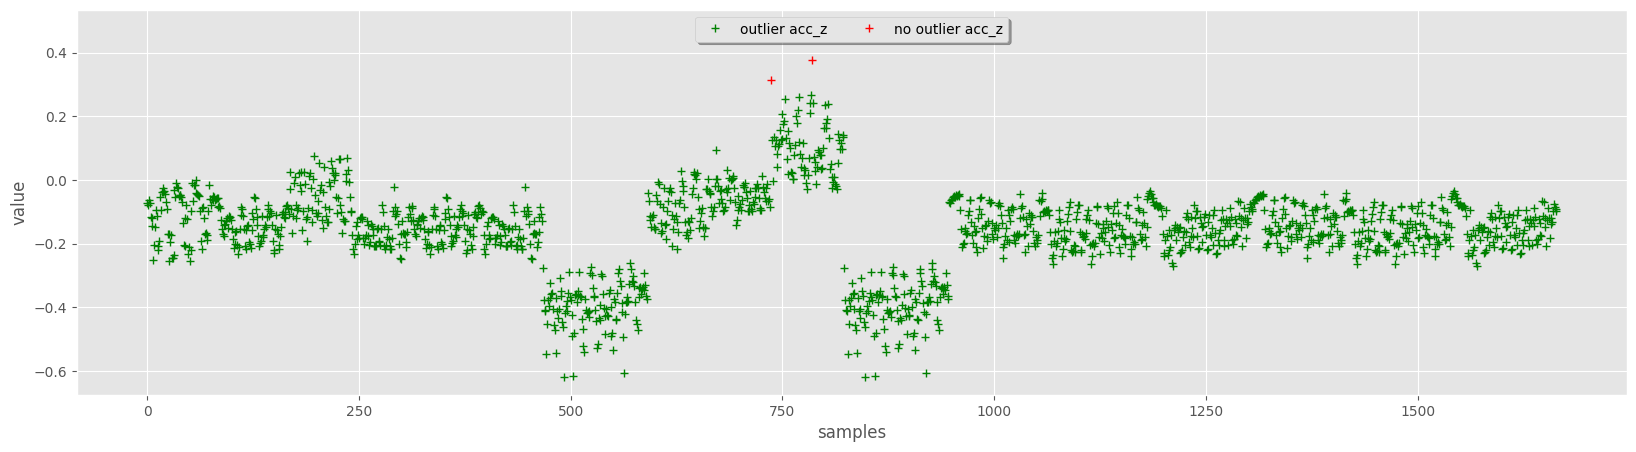

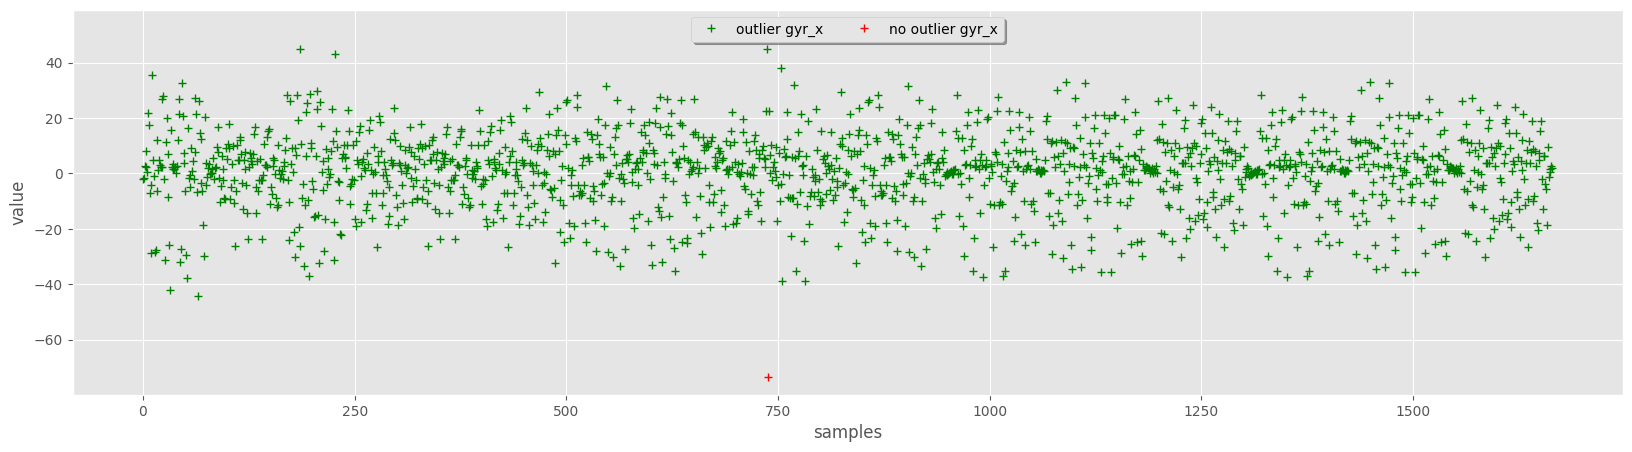

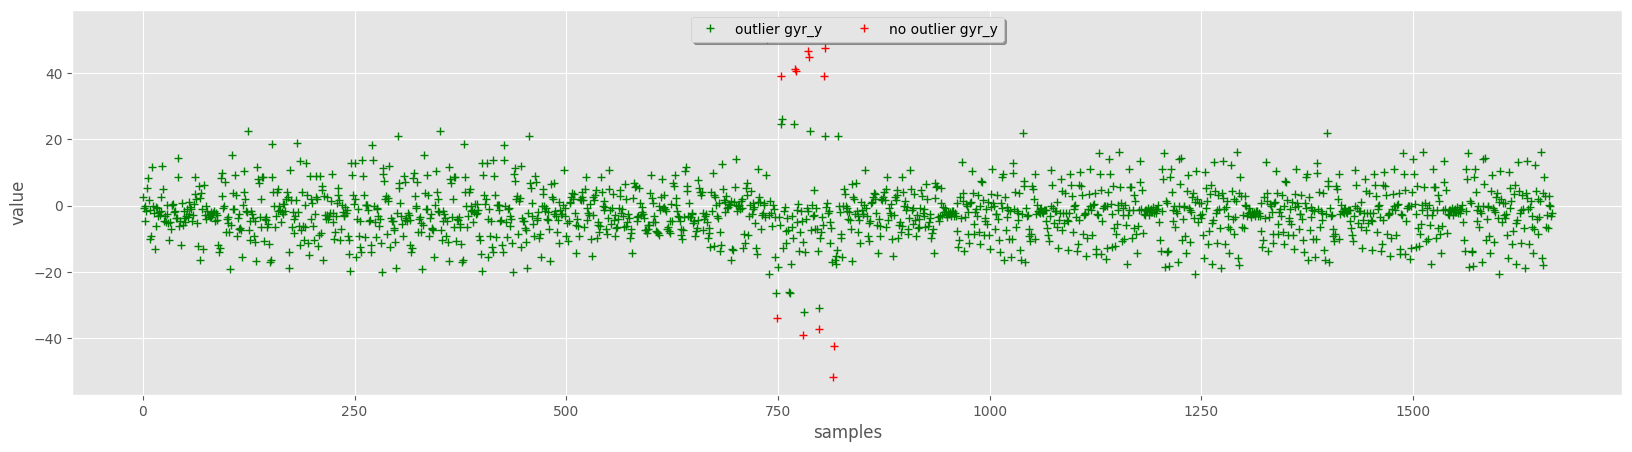

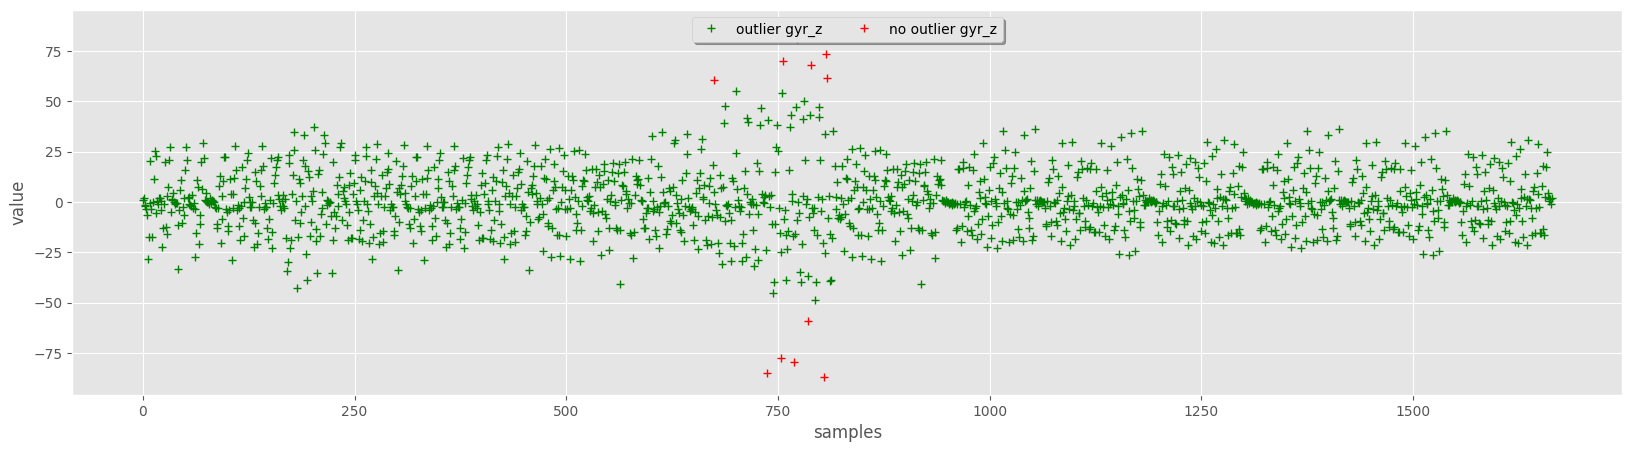

In [16]:

for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df[df["label"] == "bench"], col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )


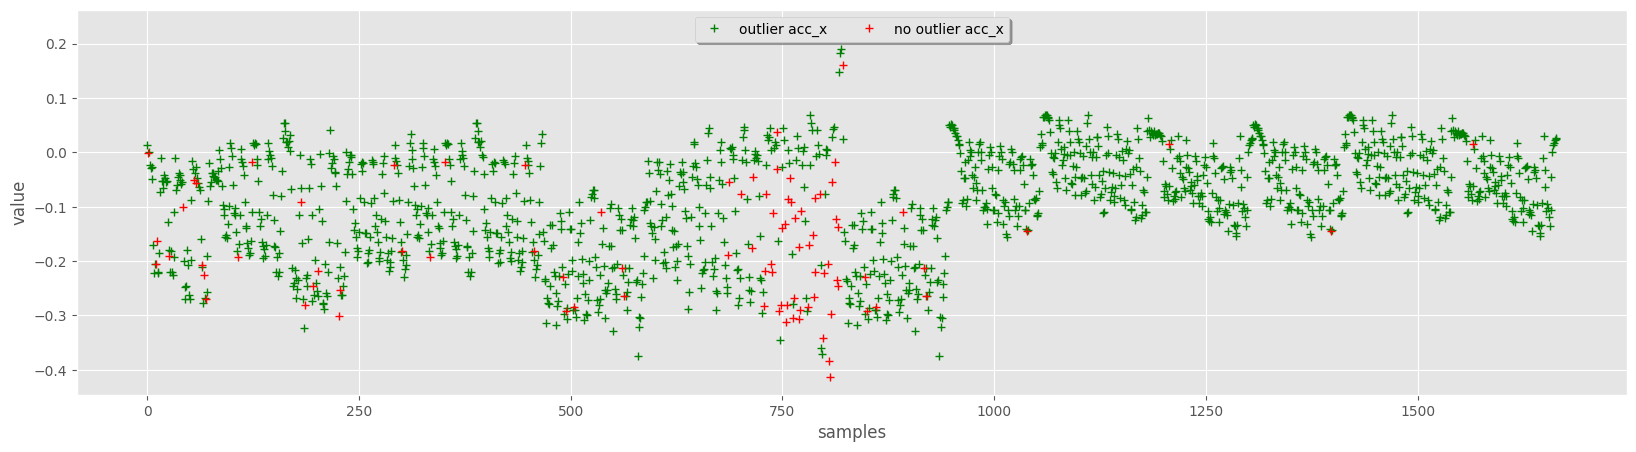

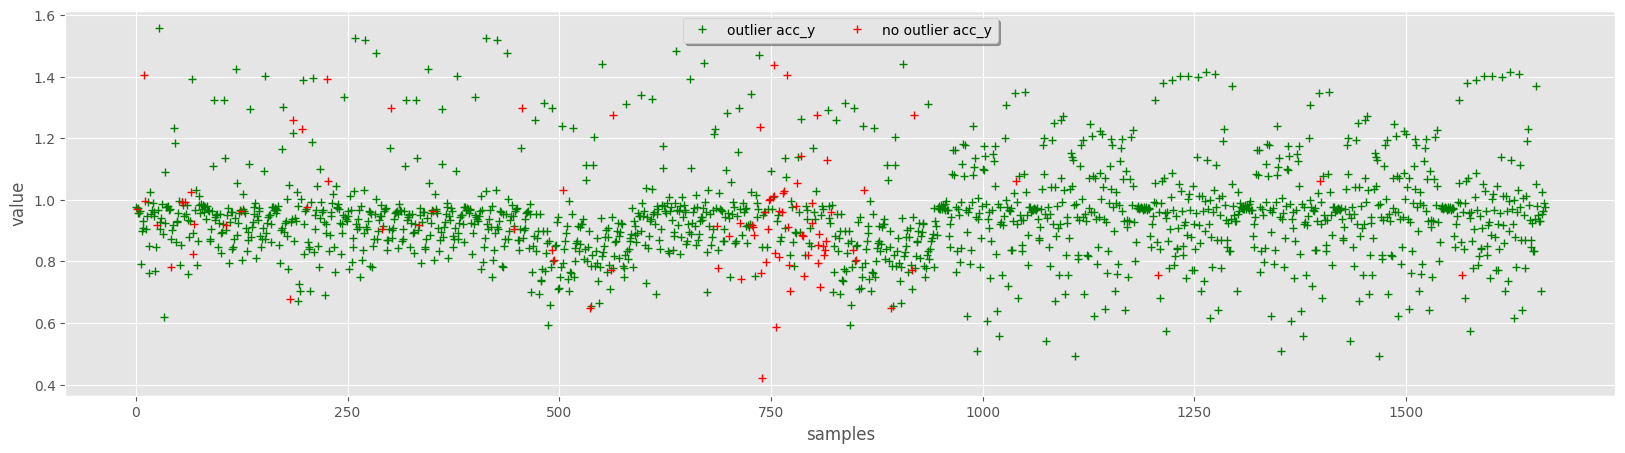

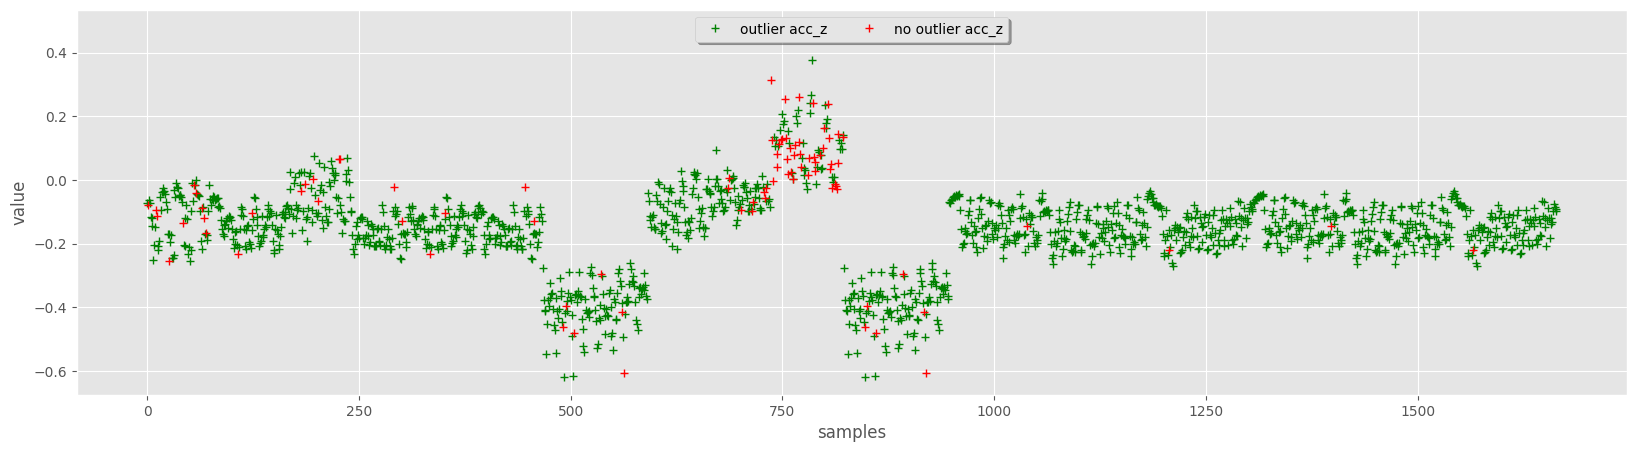

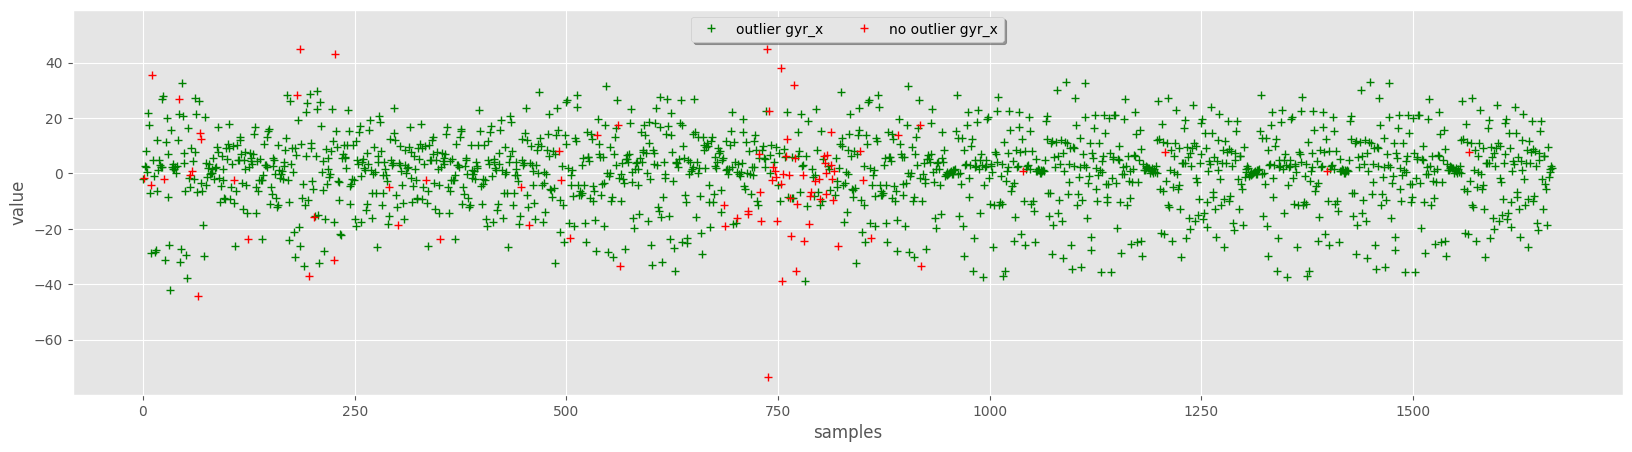

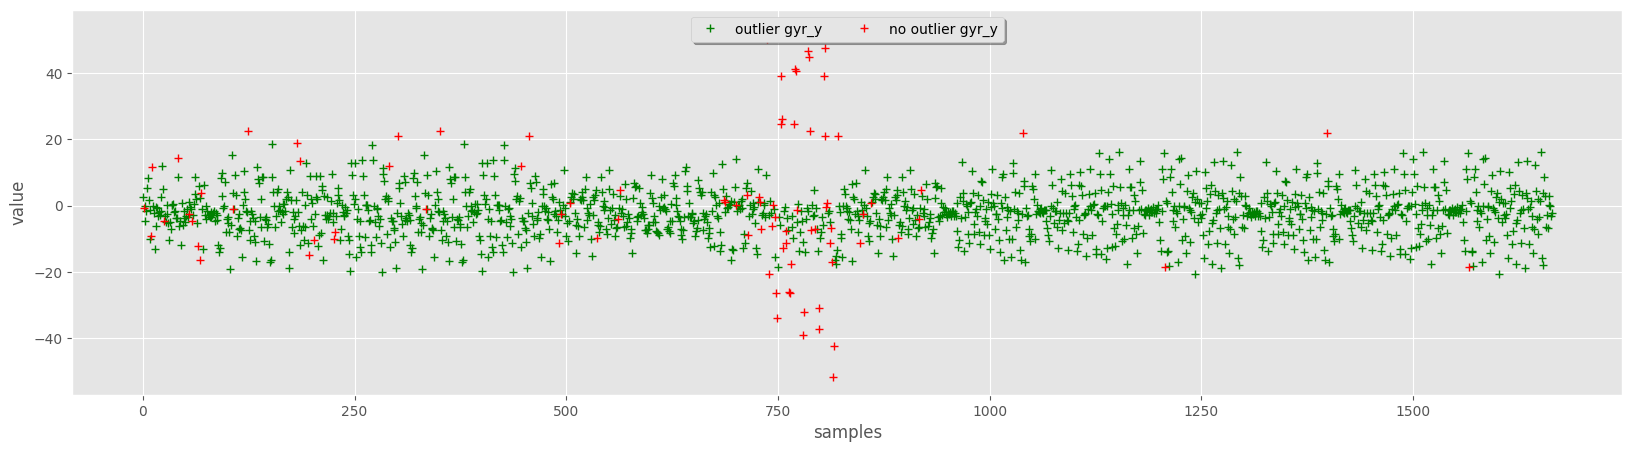

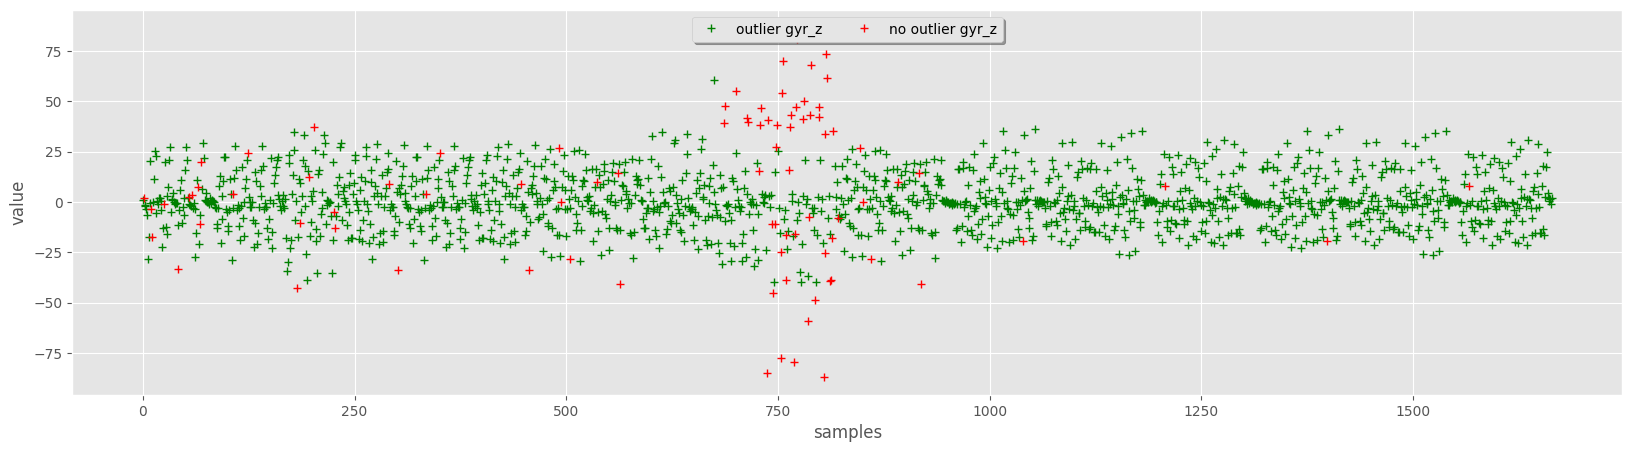

In [19]:

dataset, outliers, X_scores = mark_outliers_lof(
    df[df["label"] == "bench"], outlier_columns
)


for col in outlier_columns:
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True
    )

In [20]:

col = "gyr_z"
dataset = mark_outliers_chauvenet(df, col)
dataset[dataset["gyr_z_outlier"]]
dataset.loc[dataset["gyr_z_outlier"], "gyr_z"] = np.nan


In [21]:

# Copy the original DataFrame
outlier_removed_df = df.copy()

for col in outlier_columns:
    for label in df["label"].unique():
        # Mark outliers for each label using Chauvenet's criterion
        dataset = mark_outliers_chauvenet(df[df["label"] == label], col)

        # Set outliers to NaN
        dataset.loc[dataset[col + "_outlier"], col] = np.nan

        # Update the outlier_removed_df DataFrame with the cleaned data
        outlier_removed_df.loc[outlier_removed_df["label"] == label, col] = dataset[col]

        # Count and print the number of removed outliers
        n_outliers = len(dataset) - len(dataset[col].dropna())
        print(f"Removed {n_outliers} Outliers from {col} for {label}")


Removed 0 Outliers from acc_x for bench
Removed 2 Outliers from acc_x for ohp
Removed 0 Outliers from acc_x for squat
Removed 2 Outliers from acc_x for dead
Removed 0 Outliers from acc_x for row
Removed 0 Outliers from acc_x for rest
Removed 5 Outliers from acc_y for bench
Removed 6 Outliers from acc_y for ohp
Removed 0 Outliers from acc_y for squat
Removed 0 Outliers from acc_y for dead
Removed 0 Outliers from acc_y for row
Removed 0 Outliers from acc_y for rest
Removed 3 Outliers from acc_z for bench
Removed 6 Outliers from acc_z for ohp
Removed 0 Outliers from acc_z for squat
Removed 1 Outliers from acc_z for dead
Removed 0 Outliers from acc_z for row
Removed 0 Outliers from acc_z for rest
Removed 2 Outliers from gyr_x for bench
Removed 4 Outliers from gyr_x for ohp
Removed 1 Outliers from gyr_x for squat
Removed 6 Outliers from gyr_x for dead
Removed 0 Outliers from gyr_x for row
Removed 12 Outliers from gyr_x for rest
Removed 14 Outliers from gyr_y for bench
Removed 15 Outliers fr

In [22]:

outlier_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gyr_x        8984 non-null   float64
 1   acc_x        9005 non-null   float64
 2   acc_y        8998 non-null   float64
 3   acc_z        8999 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   label        9009 non-null   object 
 7   category     9009 non-null   object 
 8   participant  9009 non-null   object 
 9   set          9009 non-null   float64
 10  set'         9009 non-null   int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 844.6+ KB


In [23]:
outlier_removed_df.isna().sum()


gyr_x          25
acc_x           4
acc_y          11
acc_z          10
gyr_y          71
gyr_z          64
label           0
category        0
participant     0
set             0
set'            0
dtype: int64

In [24]:

# -----------------------------------------------------------
# Export the dataframe
# -----------------------------------------------------------

outlier_removed_df.to_pickle("../../../data/interim/02_outliers_removed_chauvenet.pkl")
